# Notebook per pre-elaborazione dei dati

Di seguito:
- verranno prelevati i dati e resi disponibili su variabili;
- saranno effettuate operazioni sui dati per avvicinarsi a distribuzioni gaussiane;
- verranno create nuove feature create a partire da quelle presenti e sarà valutata la loro significatività

## Scaricamento dei dati

In [1]:
# File per scaricare i dati per fare analisi di machine learning

import requests
import zipfile
import io
import os

# List of URLs to your zipped files on AWS
urls = [
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip",
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_validation_data.zip",
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_test_data.zip",
]

# Directory to save the extracted files
output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    try:
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        # Read the zip file from the response content
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extract all contents to the specified output directory
            zip_ref.extractall(output_dir)
            print(f"Extracted files from {url} to {output_dir}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except zipfile.BadZipFile:
        print(f"Error: The downloaded file from {url} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

print("Download and extraction complete.")

# Now you can access your CSV files in the 'downloaded_data' directory
# For example, to list the files in the directory:
import glob
csv_files = glob.glob(os.path.join(output_dir, "*.csv"))
print("CSV files found:", csv_files)

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to dataset
Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_validation_data.zip to dataset
Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_test_data.zip to dataset
Download and extraction complete.
CSV files found: ['dataset/X_validation.csv', 'dataset/X_test.csv', 'dataset/X_train.csv', 'dataset/y_train.csv']


## Creazione variabile dati di training

Prendo i dati di train dalla cartella e creo la variabile contenente tutti i dati e lo stato di salute delle turbine.

In [2]:
import pandas as pd

def load_training_data(x_path, y_path):
  """
  Loads X_train.csv and the second column of y_train.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X_train.csv file.
    y_path (str): The path to the y_train.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X_train.csv
                      and the second column of y_train.csv.
  """
  x_train = pd.read_csv(x_path)
  y_train = pd.read_csv(y_path)

  # Assuming y_train has at least 2 columns and the second column is at index 1
  if y_train.shape[1] > 1:
    combined_data = x_train.copy()
    combined_data['y_target'] = y_train.iloc[:, 1]
    return combined_data
  else:
    print("Error: y_train.csv does not have a second column.")
    return x_train

# Example usage:
# Assuming your files are in the 'dataset' directory as per the preceding code
x_train_path = 'dataset/X_train.csv'
y_train_path = 'dataset/y_train.csv'

data_train = load_training_data(x_train_path, y_train_path)

# You can now work with the 'training_data' DataFrame
print(data_train.head())


   id  trq_measured       oat       mgt         pa       ias         np  \
0   0        54.100   2.00000  544.5000   212.1408  74.56250   89.18000   
1   1        49.625  24.22231  578.4844  1625.6400  30.35596   99.55273   
2   2        52.000   7.00000  566.1000  1912.9250  65.62500  100.14000   
3   3        62.400   7.25000  560.1000   277.0632  54.81250   90.64000   
4   4        62.900  23.25000  593.7000    53.6448  73.43750   99.91000   

         ng  y_target  
0   99.6400         1  
1   91.3866         0  
2   90.9600         1  
3  100.2800         0  
4   92.1700         0  


## Cambio dei nomi delle feature

In [3]:
def rename_dataframe_columns(df, new_column_names):
  """
  Renames the columns of a pandas DataFrame.

  Args:
    df: The pandas DataFrame whose columns are to be renamed.
    new_column_names: A list of new column names. The length of this list
                      must match the number of columns in the DataFrame.

  Returns:
    The DataFrame with renamed columns.
  """
  if len(new_column_names) != len(df.columns):
    raise ValueError("The number of new column names must match the number of existing columns.")
  df.columns = new_column_names
  return df

# Example usage:
# Assuming you have a list of new names for your columns
new_names_for_train_data = ['idx', 'torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state'] # Replace with your desired names

# Rename the columns of data_train
# Ensure the number of names in new_names_for_train_data matches the number of columns in data_train
print(f"Number of columns in data_train: {len(data_train.columns)}")
print(f"Number of new names provided: {len(new_names_for_train_data)}")

data_train = rename_dataframe_columns(data_train, new_names_for_train_data)
print("\nDataFrame after renaming columns:")
print(data_train.head())

Number of columns in data_train: 9
Number of new names provided: 9

DataFrame after renaming columns:
   idx  torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
0    0       54.100           2.00000       544.5000     212.1408   
1    1       49.625          24.22231       578.4844    1625.6400   
2    2       52.000           7.00000       566.1000    1912.9250   
3    3       62.400           7.25000       560.1000     277.0632   
4    4       62.900          23.25000       593.7000      53.6448   

   indicated_air_speed  net_power  compressor_speed  health_state  
0             74.56250   89.18000           99.6400             1  
1             30.35596   99.55273           91.3866             0  
2             65.62500  100.14000           90.9600             1  
3             54.81250   90.64000          100.2800             0  
4             73.43750   99.91000           92.1700             0  


## Esplorazione dati

In [4]:
print("Informazioni di base sulle colonne:")
print(data_train.info())

print("\Statistiche descrittive delle colonne:")
print(data_train.describe())

Informazioni di base sulle colonne:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742625 entries, 0 to 742624
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   idx                  742625 non-null  int64  
 1   torque_meas          742625 non-null  float64
 2   outside_air_temp     742625 non-null  float64
 3   mean_gas_temp        742625 non-null  float64
 4   power_avail          742625 non-null  float64
 5   indicated_air_speed  742625 non-null  float64
 6   net_power            742625 non-null  float64
 7   compressor_speed     742625 non-null  float64
 8   health_state         742625 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 51.0 MB
None
\Statistiche descrittive delle colonne:
                 idx    torque_meas  outside_air_temp  mean_gas_temp  \
count  742625.000000  742625.000000     742625.000000  742625.000000   
mean   371312.000000      65.097549         12.675167

## Standardizzazione

In [5]:
from sklearn.preprocessing import MinMaxScaler

def standardize_columns(df, columns_to_standardize):
  """
  Standardizes specified columns of a pandas DataFrame to have values between 0 and 1
  using MinMaxScaler.

  Args:
    df: The pandas DataFrame to standardize.
    columns_to_standardize: A list of column names to standardize.

  Returns:
    The DataFrame with the specified columns standardized.
  """
  scaler = MinMaxScaler()
  df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
  return df

# Example usage:
# Assuming you want to standardize all numerical columns except the index and the target variable
# Identify numerical columns (excluding 'idx' and 'health_state' in this case)
numerical_cols = data_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
columns_to_standardize = [col for col in numerical_cols if col not in ['idx', 'health_state']]

print(f"\nColumns to standardize: {columns_to_standardize}")

data_train_standardized = standardize_columns(data_train.copy(), columns_to_standardize)

print("\nDataFrame after standardization:")
print(data_train_standardized.head())
print("\nDescriptive statistics after standardization:")
print(data_train_standardized.describe())


Columns to standardize: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed']

DataFrame after standardization:
   idx  torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
0    0     0.437796          0.379132       0.301445     0.127206   
1    1     0.388105          0.775611       0.434144     0.554775   
2    2     0.414477          0.468339       0.385787     0.641675   
3    3     0.529960          0.472799       0.362358     0.146844   
4    4     0.535512          0.758263       0.493557     0.079263   

   indicated_air_speed  net_power  compressor_speed  health_state  
0             0.542026   0.251964          0.859157             1  
1             0.220670   0.878715          0.123440             0  
2             0.477056   0.914199          0.085412             1  
3             0.398455   0.340181          0.916207             0  
4             0.533848   0.900302          0.193273           

## Power available

Ha un andamento che tende a sinistra, quindi con coda a destra (right skewed), infatti la media è maggiore della mediana

### Logaritmo

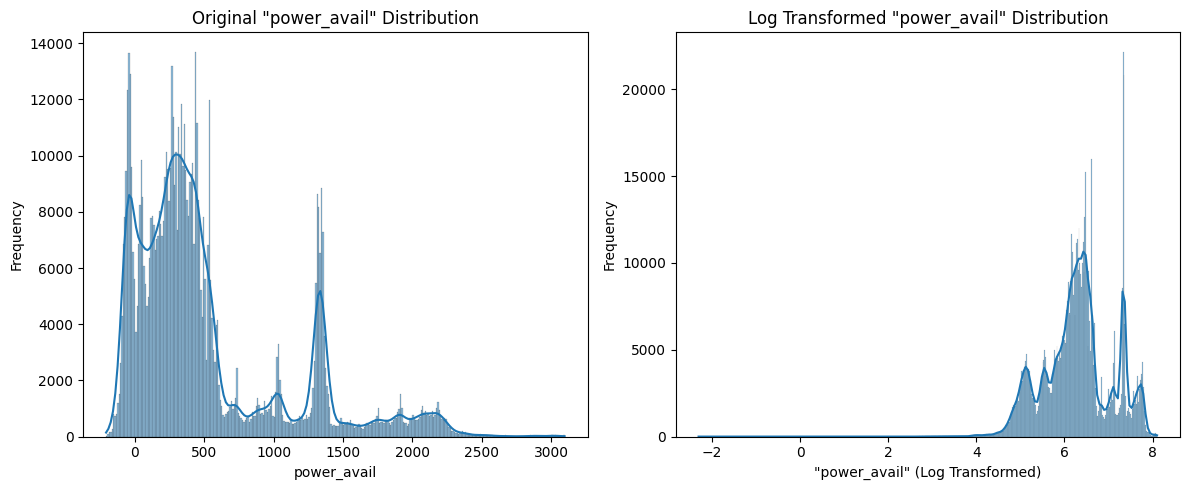


Descriptive statistics for original and transformed 'power_avail':
         power_avail  power_avail_log_transformed
count  742625.000000                742625.000000
mean      511.776065                     6.299038
std       563.190555                     0.764488
min      -208.389200                    -2.302585
25%       135.331200                     5.840119
50%       340.461600                     6.308009
75%       588.264000                     6.680545
max      3097.510000                     8.103494


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def transform_right_skewed(df, column_name):
  """
  Applies a logarithmic transformation to a right-skewed column to make it more Gaussian-like.
  Handles zero and negative values by adding a small constant.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  # Add a small constant to handle zero or negative values before log transform
  # This constant is often the absolute value of the minimum plus a small epsilon
  min_val = df[column_name].min()
  if min_val <= 0:
      constant = abs(min_val) + 1e-1
      df[f'{column_name}_log_transformed'] = np.log(df[column_name] + constant)
  else:
      df[f'{column_name}_log_transformed'] = np.log(df[column_name])

  return df

# Apply the transformation to the 'power_avail' column
data_train = transform_right_skewed(data_train.copy(), 'power_avail')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['power_avail'], kde=True)
plt.title('Original "power_avail" Distribution')
plt.xlabel('power_avail')
plt.ylabel('Frequency')

# Transformed histogram
plt.subplot(1, 2, 2)
sns.histplot(data_train['power_avail_log_transformed'], kde=True)
plt.title('Log Transformed "power_avail" Distribution')
plt.xlabel('"power_avail" (Log Transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and transformed 'power_avail':")
print(data_train[['power_avail', 'power_avail_log_transformed']].describe())


### Radice quadrata

Trasformando i dati con la radice quadrata sono stati ottenuti valori più centrati, la media è più vicina alla mediana di prima.

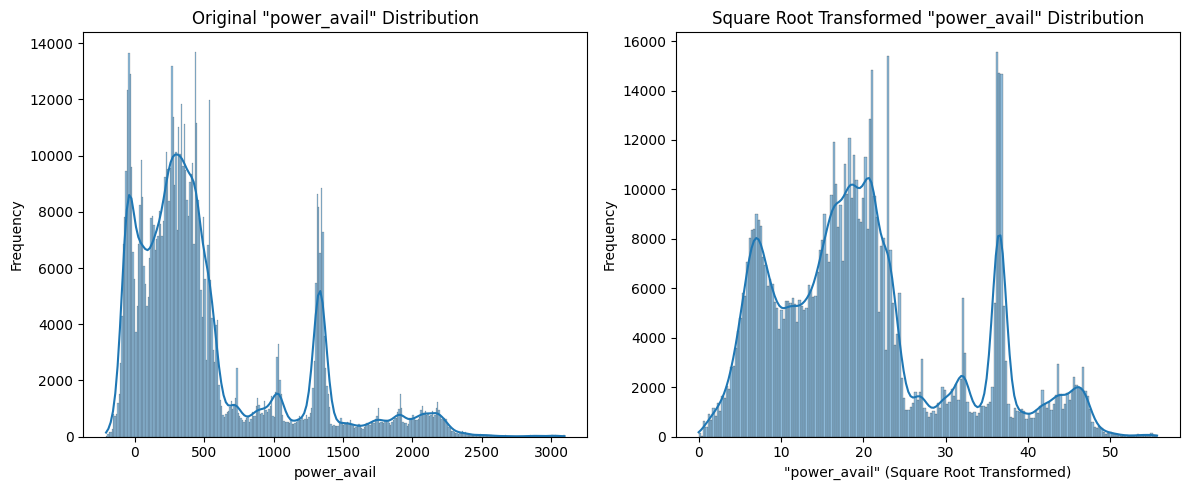


Descriptive statistics for original and sqrt transformed 'power_avail':
         power_avail  power_avail_sqrt_transformed
count  742625.000000                 742625.000000
mean      511.776065                     20.063864
std       563.190555                     11.103680
min      -208.389200                      0.000000
25%       135.331200                     11.763469
50%       340.461600                     18.451602
75%       588.264000                     24.254154
max      3097.510000                     55.655278


In [7]:
def transform_with_sqrt(df, column_name):
  """
  Applies a square root transformation to a column.
  Ensures values are non-negative before applying the square root.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  # Ensure values are non-negative before applying square root
  # You might want to handle negative values differently based on your data context
  if (df[column_name] < 0).any():
      print(f"Warning: Column '{column_name}' contains negative values. Applying sqrt to absolute values.")
      df[f'{column_name}_sqrt_transformed'] = np.sqrt(np.abs(df[column_name]))
  else:
      df[f'{column_name}_sqrt_transformed'] = np.sqrt(df[column_name])

  return df

# Apply the square root transformation to the 'power_avail' column
data_train = transform_with_sqrt(data_train.copy(), 'power_avail')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['power_avail'], kde=True)
plt.title('Original "power_avail" Distribution')
plt.xlabel('power_avail')
plt.ylabel('Frequency')

# Transformed histogram (Square Root)
plt.subplot(1, 2, 2)
sns.histplot(data_train['power_avail_sqrt_transformed'], kde=True)
plt.title('Square Root Transformed "power_avail" Distribution')
plt.xlabel('"power_avail" (Square Root Transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and sqrt transformed 'power_avail':")
print(data_train[['power_avail', 'power_avail_sqrt_transformed']].describe())

### Radice cubica

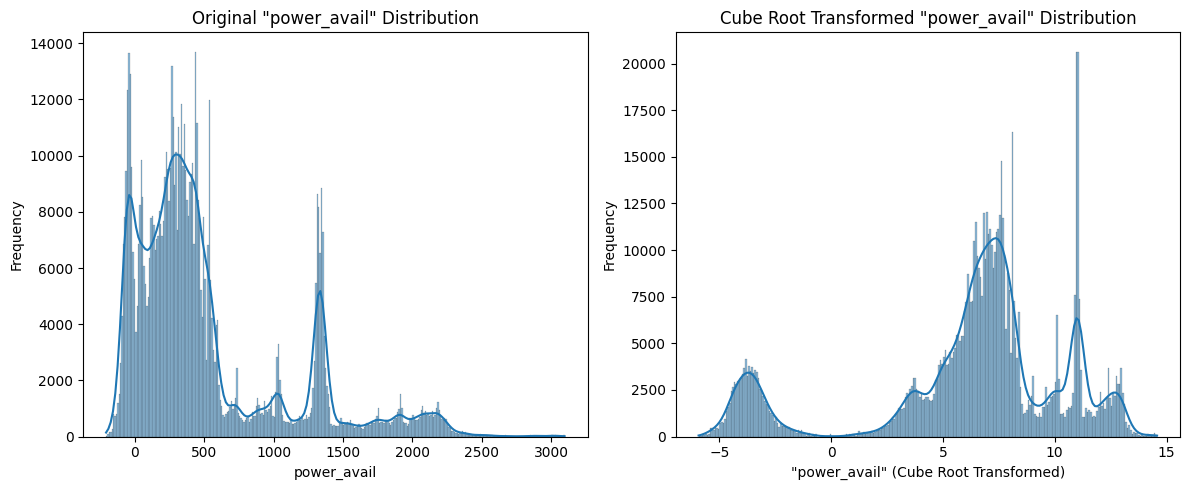


Descriptive statistics for original and cbrt transformed 'power_avail':
         power_avail  power_avail_cbrt_transformed
count  742625.000000                 742625.000000
mean      511.776065                      6.187576
std       563.190555                      4.458110
min      -208.389200                     -5.928685
25%       135.331200                      5.134120
50%       340.461600                      6.982689
75%       588.264000                      8.378972
max      3097.510000                     14.577092


In [8]:
def transform_with_cbrt(df, column_name):
  """
  Applies a cube root transformation to a column.
  The cube root can handle positive, negative, and zero values.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  df[f'{column_name}_cbrt_transformed'] = np.cbrt(df[column_name])
  return df

# Apply the cube root transformation to the 'power_avail' column
data_train = transform_with_cbrt(data_train.copy(), 'power_avail')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['power_avail'], kde=True)
plt.title('Original "power_avail" Distribution')
plt.xlabel('power_avail')
plt.ylabel('Frequency')

# Transformed histogram (Cube Root)
plt.subplot(1, 2, 2)
sns.histplot(data_train['power_avail_cbrt_transformed'], kde=True)
plt.title('Cube Root Transformed "power_avail" Distribution')
plt.xlabel('"power_avail" (Cube Root Transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and cbrt transformed 'power_avail':")
print(data_train[['power_avail', 'power_avail_cbrt_transformed']].describe())

### Radice custom
La radice quadrata funziona abbastanza bene, provo a vedere se per caso si riesce a fare meglio

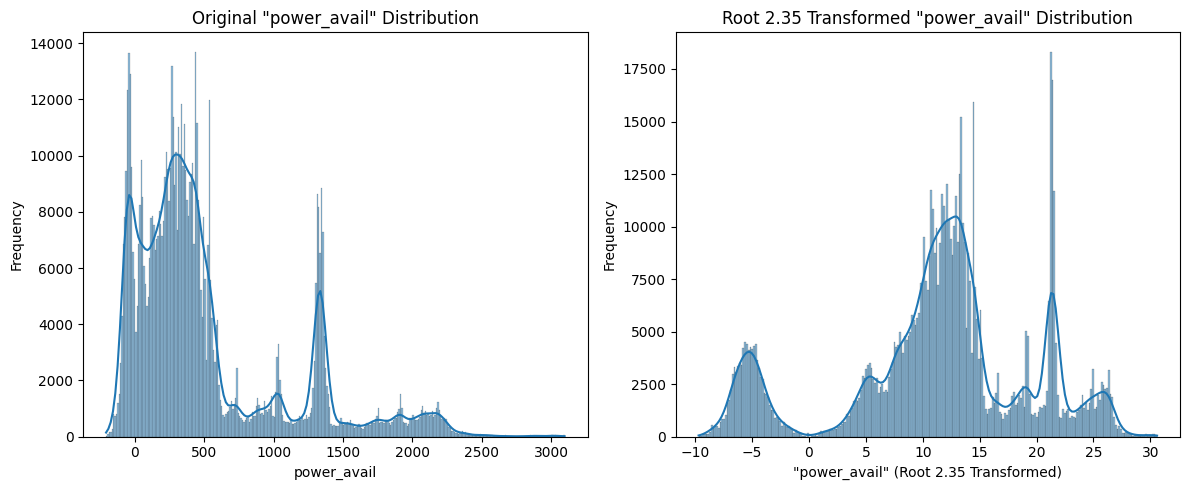


Descriptive statistics for original and root 2.35 transformed 'power_avail':
         power_avail  power_avail_root_2.35_transformed
count  742625.000000                      742625.000000
mean      511.776065                          11.233921
std       563.190555                           8.262459
min      -208.389200                          -9.699635
25%       135.331200                           8.071938
50%       340.461600                          11.952969
75%       588.264000                          15.084864
max      3097.510000                          30.587031


In [9]:
def transform_with_custom_root(df, column_name, root_degree):
  """
  Applies a custom root transformation (1/root_degree power) to a column.
  Handles positive, negative, and zero values appropriately based on the root degree.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.
    root_degree (float): The degree of the root (e.g., 2 for square root, 3 for cube root).

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  new_column_name = f'{column_name}_root_{root_degree:.2f}_transformed'

  if root_degree == 0:
      raise ValueError("Root degree cannot be zero.")
  elif root_degree % 2 == 0:  # Even root
      # For even roots, we can only take the root of non-negative numbers
      if (df[column_name] < 0).any():
          print(f"Warning: Column '{column_name}' contains negative values. Cannot apply even root directly.")
          # You might choose to handle this by taking the root of the absolute value,
          # or setting negative values to NaN, depending on your data context.
          # Here, we'll take the root of the absolute value for demonstration.
          df[new_column_name] = np.power(np.abs(df[column_name]), 1/root_degree)
      else:
          df[new_column_name] = np.power(df[column_name], 1/root_degree)
  else:  # Odd root
      # Odd roots can handle positive, negative, and zero values
      df[new_column_name] = np.sign(df[column_name]) * np.power(np.abs(df[column_name]), 1/root_degree)

  return df

# Example usage with a custom root (e.g., 1.5)
custom_root_degree = 2.35
data_train = transform_with_custom_root(data_train.copy(), 'power_avail', custom_root_degree)
new_transformed_col_name = f'power_avail_root_{custom_root_degree:.2f}_transformed'

# Plot histograms before and after custom root transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['power_avail'], kde=True)
plt.title('Original "power_avail" Distribution')
plt.xlabel('power_avail')
plt.ylabel('Frequency')

# Transformed histogram (Custom Root)
plt.subplot(1, 2, 2)
sns.histplot(data_train[new_transformed_col_name], kde=True)
plt.title(f'Root {custom_root_degree:.2f} Transformed "power_avail" Distribution')
plt.xlabel(f'"power_avail" (Root {custom_root_degree:.2f} Transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nDescriptive statistics for original and root {custom_root_degree:.2f} transformed 'power_avail':")
print(data_train[['power_avail', new_transformed_col_name]].describe())

# You can try different root degrees to see which one results in a distribution
# that is closer to a normal distribution. For example, you could iterate through
# a range of values for `custom_root_degree`.


### Radice custom di valore assoluto

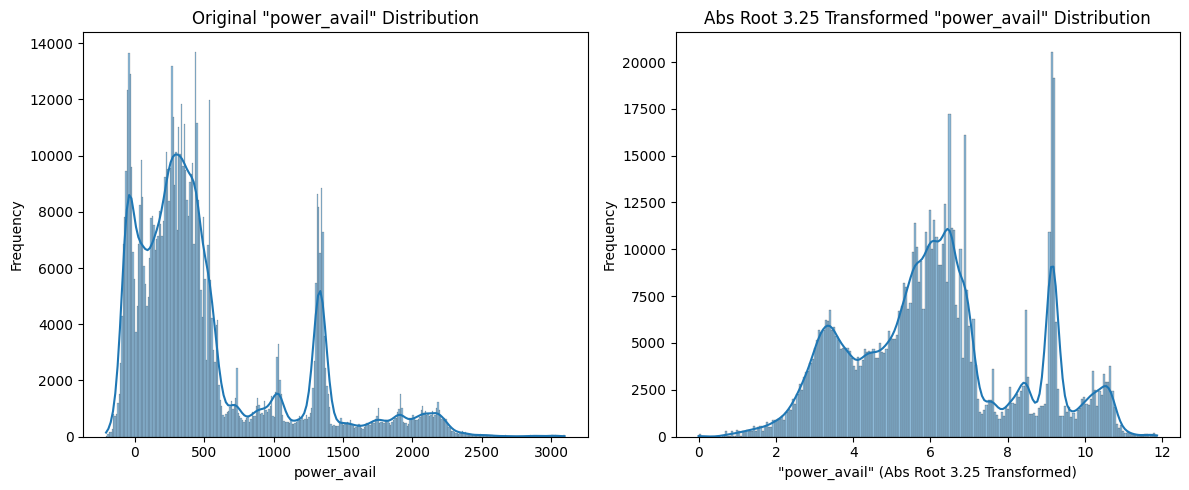


Descriptive statistics for original and abs root 3.25 transformed 'power_avail':
         power_avail  power_avail_abs_root_3.25_transformed
count  742625.000000                          742625.000000
mean      511.776065                               6.094815
std       563.190555                               2.156812
min      -208.389200                               0.000000
25%       135.331200                               4.558175
50%       340.461600                               6.013093
75%       588.264000                               7.115019
max      3097.510000                              11.861996


In [31]:
def transform_with_abs_custom_root(df, column_name, root_degree):
  """
  Applies a custom root transformation (1/root_degree power) to the absolute value of a column.
  Then applies the original sign back.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.
    root_degree (float): The degree of the root (e.g., 2 for square root, 3 for cube root).

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  new_column_name = f'{column_name}_abs_root_{root_degree:.2f}_transformed'

  if root_degree == 0:
      raise ValueError("Root degree cannot be zero.")

  # Take the root of the absolute value
  df[new_column_name] = np.power(np.abs(df[column_name]), 1/root_degree)

  #df[new_column_name] = df[new_column_name] * np.sign(df[column_name])

  return df

# Apply the transformation to the 'power_avail' column using the new function
custom_root_degree = 3.25 # You can experiment with different root degrees
data_train = transform_with_abs_custom_root(data_train.copy(), 'power_avail', custom_root_degree)
new_transformed_col_name = f'power_avail_abs_root_{custom_root_degree:.2f}_transformed'

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['power_avail'], kde=True)
plt.title('Original "power_avail" Distribution')
plt.xlabel('power_avail')
plt.ylabel('Frequency')

# Transformed histogram
plt.subplot(1, 2, 2)
sns.histplot(data_train[new_transformed_col_name], kde=True)
plt.title(f'Abs Root {custom_root_degree:.2f} Transformed "power_avail" Distribution')
plt.xlabel(f'"power_avail" (Abs Root {custom_root_degree:.2f} Transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nDescriptive statistics for original and abs root {custom_root_degree:.2f} transformed 'power_avail':")
print(data_train[['power_avail', new_transformed_col_name]].describe())

### Segno di power available
Utilizzando una trasformazione con elevamento alla 1/3.25 per i valori di power_avail in valore assoluto si ottiene una distribuzione più vicina ad una distribuzione normale, tuttavia il rischio è di perdere l'informazione contenuta nel segno. Vorrei quindi valutare se questo contenuto è rilevante, quindi valutare se occorra utilizzare una funzione di estrazione di segno o meno.

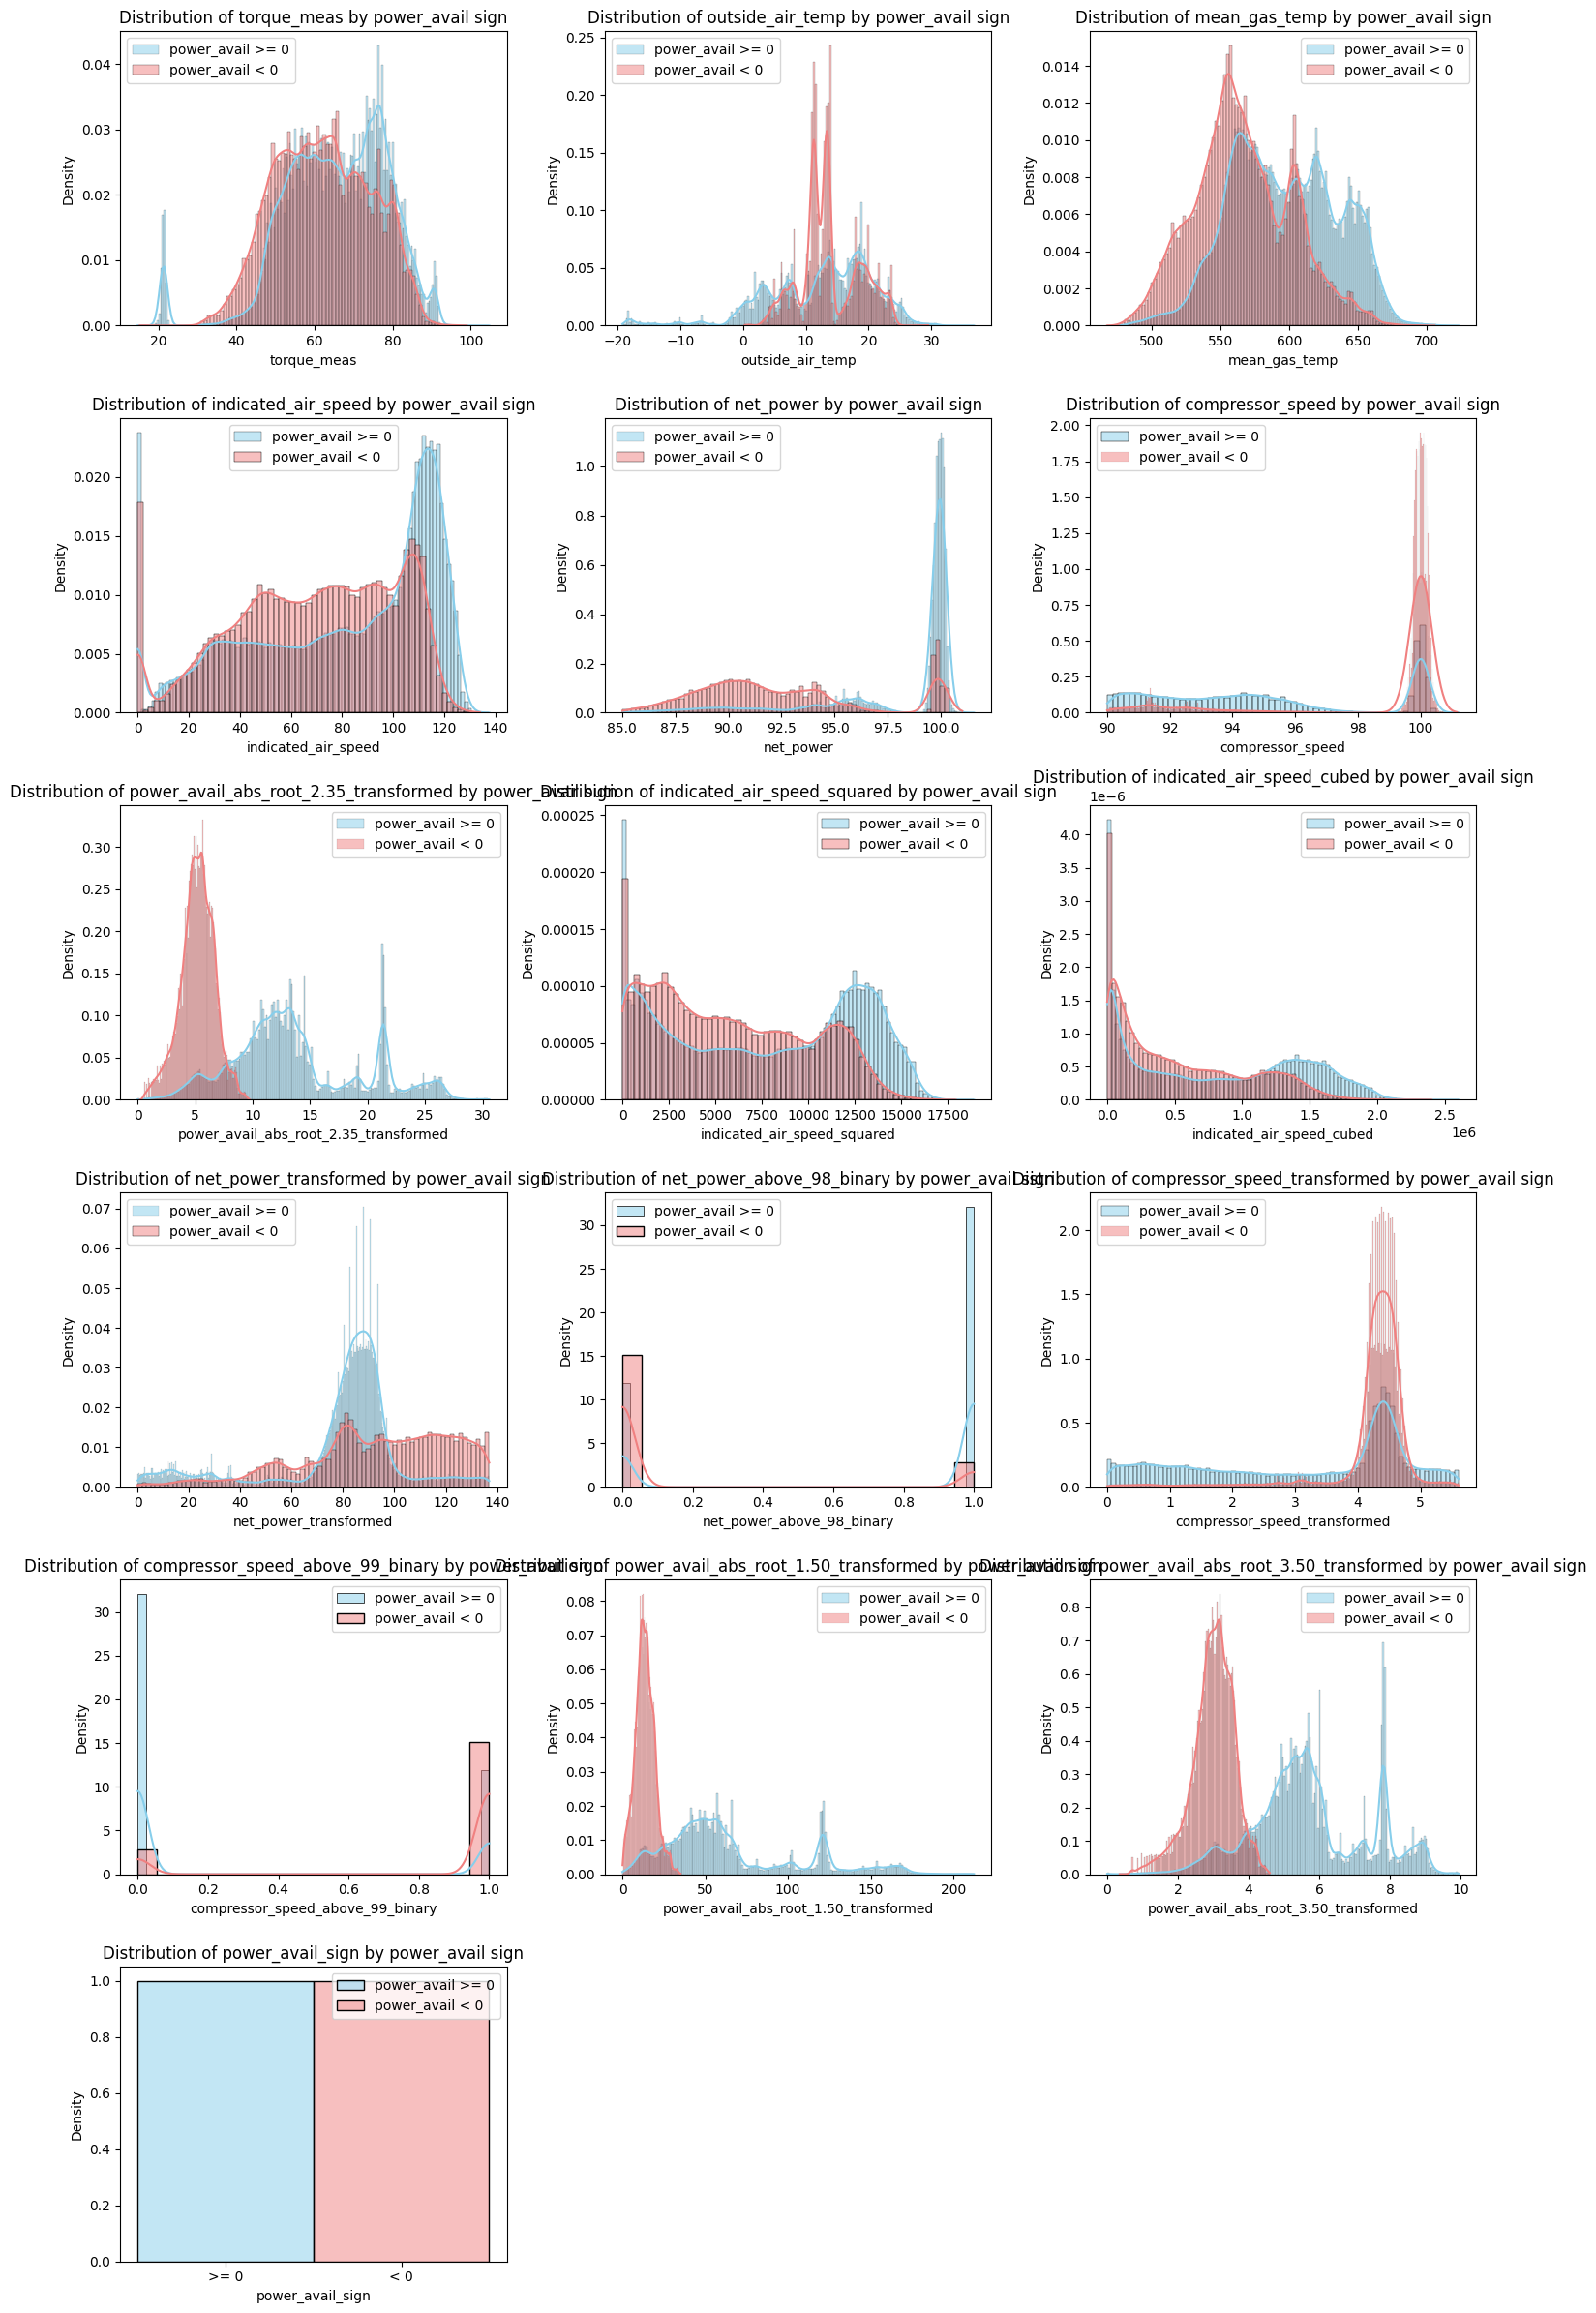

In [37]:
# prompt: vorrei per il segno di power_avail (non trasformato) vedere come variano le altre feature, i grafici vorrei istogrammi con sovrapposta una curva nel continuo che permetta di cogliere gli andamenti e con colori ben distinti (raggruppati in un unica figura) e boxplot (raggruppati tutti in un altra figura)

# Separate data based on the sign of 'power_avail'
data_positive = data_train[data_train['power_avail'] >= 0]
data_negative = data_train[data_train['power_avail'] < 0]

# List of features to visualize (excluding 'idx' and target variables)
features_to_plot = [col for col in data_train.columns if col not in ['idx', 'health_state', 'y_target',
                                                                    'power_avail_log_transformed',
                                                                    'power_avail_sqrt_transformed',
                                                                    'power_avail_cbrt_transformed',
                                                                    'power_avail_root_2.35_transformed',
                                                                    'power_avail_abs_root_3.25_transformed',
                                                                    'power_avail']] # Exclude power_avail itself and transformed versions


# --- Histograms with KDE ---
n_features = len(features_to_plot)
n_cols = 3 # Number of columns in the plot grid
n_rows = (n_features + n_cols - 1) // n_cols # Calculate number of rows needed

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, feature in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=data_positive, x=feature, kde=True, color='skyblue', label='power_avail >= 0', stat='density', common_norm=False)
    sns.histplot(data=data_negative, x=feature, kde=True, color='lightcoral', label='power_avail < 0', stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} by power_avail sign')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

# Remove the temporary sign column
data_train = data_train.drop(columns=['power_avail_sign'])

## Indicated Air Speed
La variabile indicated_air_speed ha un picco molto a destra, quindi una coda a sinistra (left skewed), infatti ha una media minore della mediana

### Elevamento al quadrato

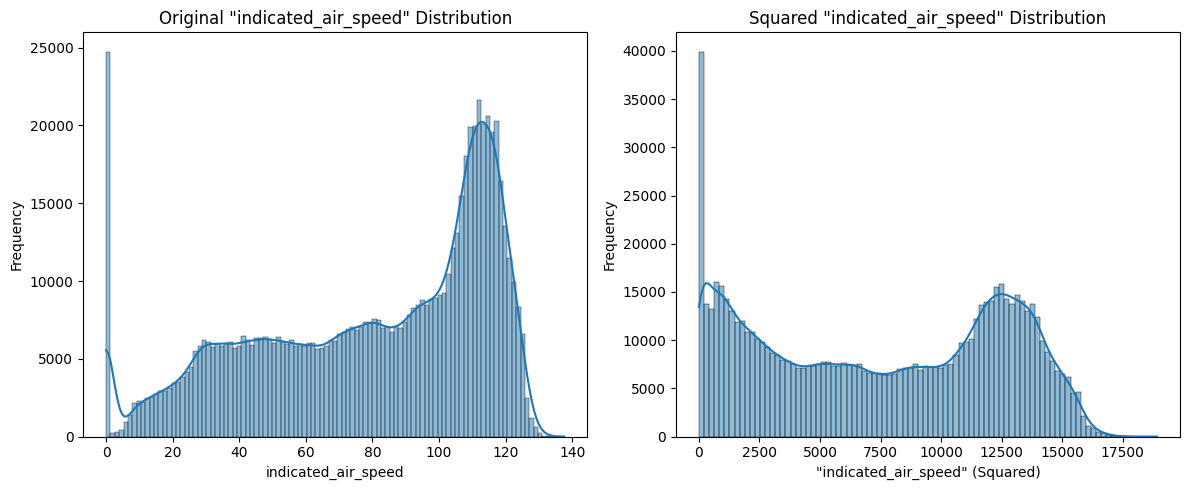


Descriptive statistics for original and squared 'indicated_air_speed':
       indicated_air_speed  indicated_air_speed_squared
count        742625.000000                742625.000000
mean             79.324591                  7545.200440
std              35.395075                  4991.638173
min               0.000000                     0.000000
25%              51.125000                  2613.765625
50%              88.375000                  7810.140625
75%             110.562500                 12224.066406
max             137.562500                 18923.441406


In [11]:
def transform_with_square(df, column_name):
  """
  Applies a square transformation to a column.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  df[f'{column_name}_squared'] = df[column_name] ** 2
  return df

# Apply the square transformation to the 'indicated_air_speed' column
data_train = transform_with_square(data_train.copy(), 'indicated_air_speed')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['indicated_air_speed'], kde=True)
plt.title('Original "indicated_air_speed" Distribution')
plt.xlabel('indicated_air_speed')
plt.ylabel('Frequency')

# Transformed histogram (Squared)
plt.subplot(1, 2, 2)
sns.histplot(data_train['indicated_air_speed_squared'], kde=True)
plt.title('Squared "indicated_air_speed" Distribution')
plt.xlabel('"indicated_air_speed" (Squared)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and squared 'indicated_air_speed':")
print(data_train[['indicated_air_speed', 'indicated_air_speed_squared']].describe())


### Elevamento al cubo

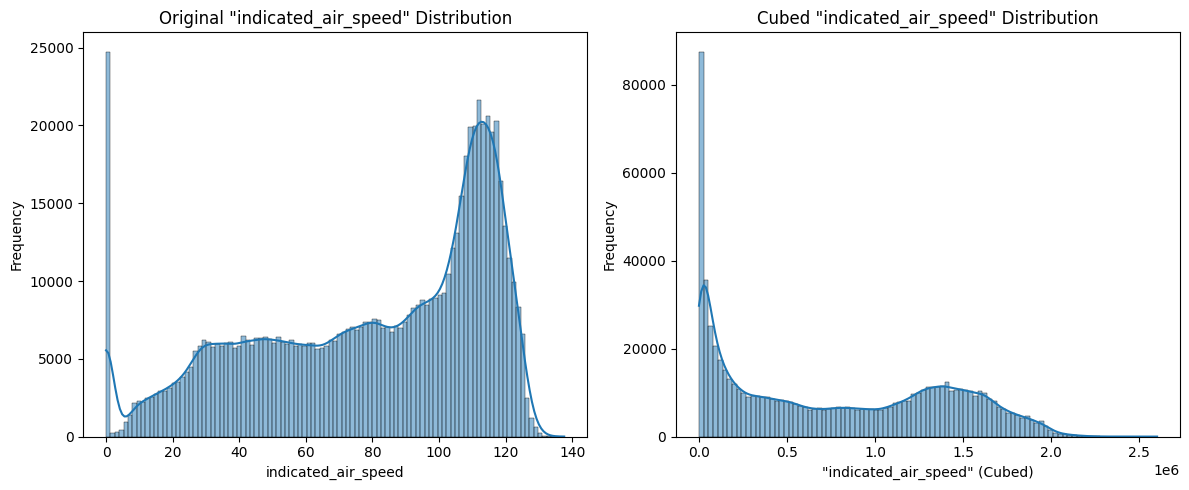


Descriptive statistics for original and cubed 'indicated_air_speed':
       indicated_air_speed  indicated_air_speed_cubed
count        742625.000000               7.426250e+05
mean             79.324591               7.705318e+05
std              35.395075               6.265593e+05
min               0.000000               0.000000e+00
25%              51.125000               1.336288e+05
50%              88.375000               6.902212e+05
75%             110.562500               1.351523e+06
max             137.562500               2.603156e+06


In [12]:
def transform_with_cube(df, column_name):
  """
  Applies a cube transformation to a column.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  df[f'{column_name}_cubed'] = df[column_name] ** 3
  return df

# Apply the cube transformation to the 'indicated_air_speed' column
data_train = transform_with_cube(data_train.copy(), 'indicated_air_speed')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['indicated_air_speed'], kde=True)
plt.title('Original "indicated_air_speed" Distribution')
plt.xlabel('indicated_air_speed')
plt.ylabel('Frequency')

# Transformed histogram (Cubed)
plt.subplot(1, 2, 2)
sns.histplot(data_train['indicated_air_speed_cubed'], kde=True)
plt.title('Cubed "indicated_air_speed" Distribution')
plt.xlabel('"indicated_air_speed" (Cubed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and cubed 'indicated_air_speed':")
print(data_train[['indicated_air_speed', 'indicated_air_speed_cubed']].describe())


### Air speed 0
Noto che ci sono tanti valori con indicated air speed nulla, vorrei cercare di indagare per capire meglio in che condizioni si verifica

In [13]:
# Filter the DataFrame where 'indicated_air_speed' is 0
indicated_air_speed_zero_data = data_train[data_train['indicated_air_speed'] == 0].copy()

# Select the specified columns
selected_columns_at_zero_speed = indicated_air_speed_zero_data[[
    'torque_meas',
    'outside_air_temp',
    'mean_gas_temp',
    'power_avail_sqrt_transformed',
    'indicated_air_speed',
    'net_power',
    'compressor_speed',
    'health_state'
]]

# Display the head of the new DataFrame
print("\nData where 'indicated_air_speed' is 0 for selected columns:")
print(selected_columns_at_zero_speed.head())

# Display descriptive statistics for these columns when speed is zero
print("\nDescriptive statistics for selected columns where 'indicated_air_speed' is 0:")
print(selected_columns_at_zero_speed.describe())


Data where 'indicated_air_speed' is 0 for selected columns:
     torque_meas  outside_air_temp  mean_gas_temp  \
34          75.1             14.25          636.4   
82          75.0             29.00          662.6   
84          72.1             17.50          622.3   
179         67.9             15.25          608.2   
185         57.2             24.25          593.4   

     power_avail_sqrt_transformed  indicated_air_speed  net_power  \
34                      15.399169                  0.0      95.74   
82                      16.971623                  0.0      99.82   
84                       8.850627                  0.0      99.80   
179                     17.414821                  0.0      99.79   
185                     11.461623                  0.0      91.76   

     compressor_speed  health_state  
34             100.38             0  
82              96.68             1  
84              93.94             1  
179             93.73             1  
185            


Histograms of variables when 'indicated_air_speed' is 0:


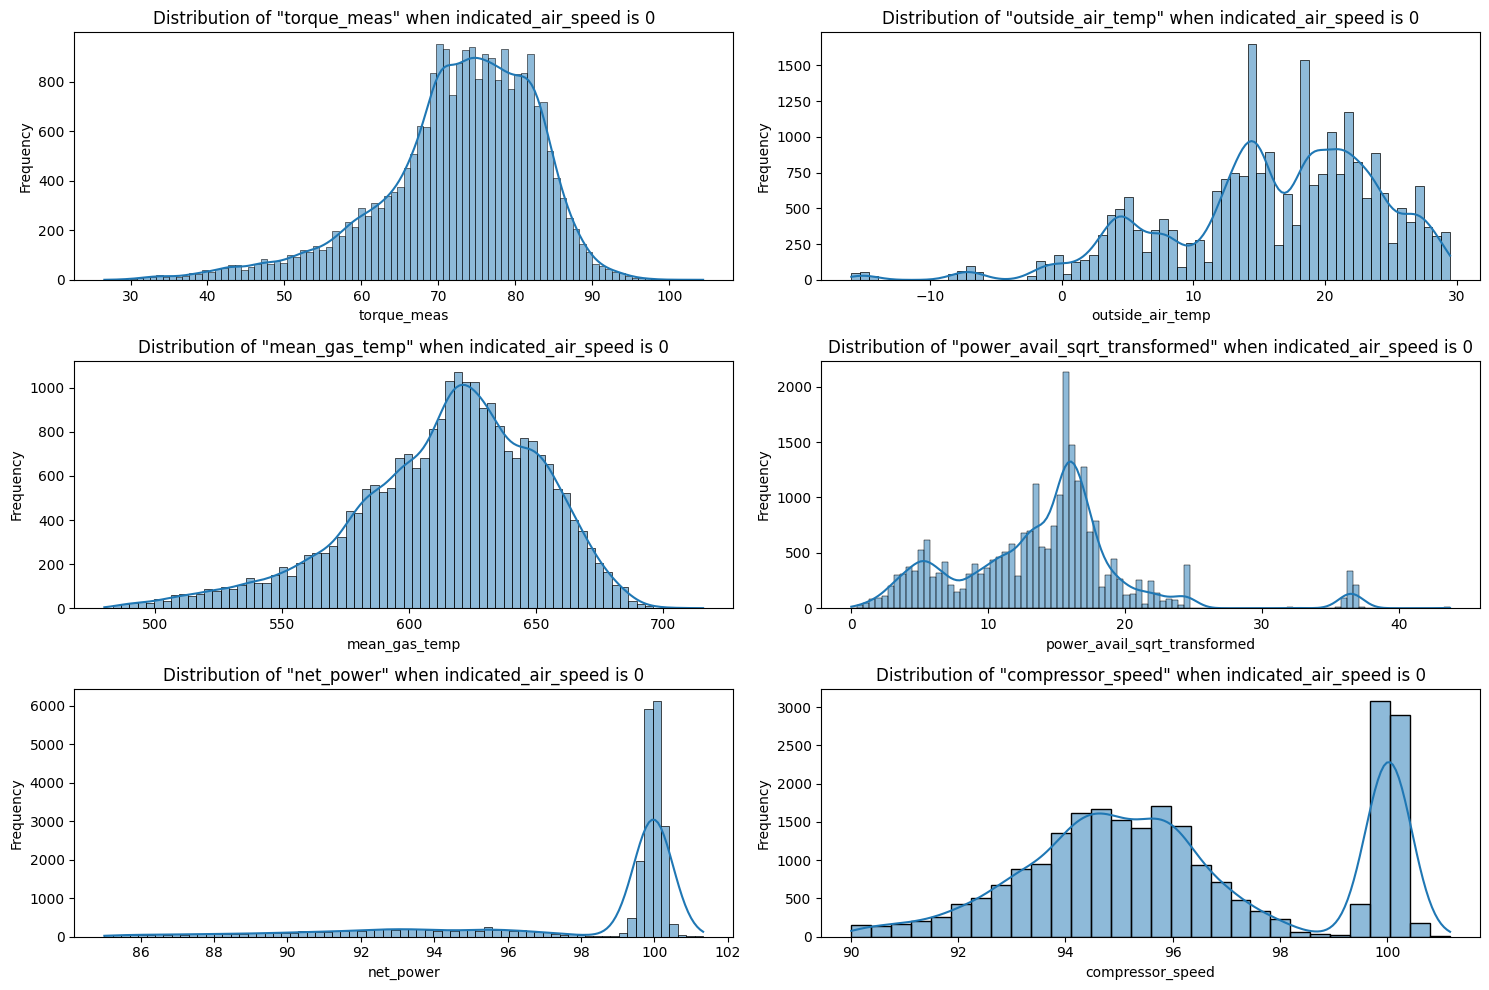


Relationship between selected variables and 'health_state' when 'indicated_air_speed' is 0:


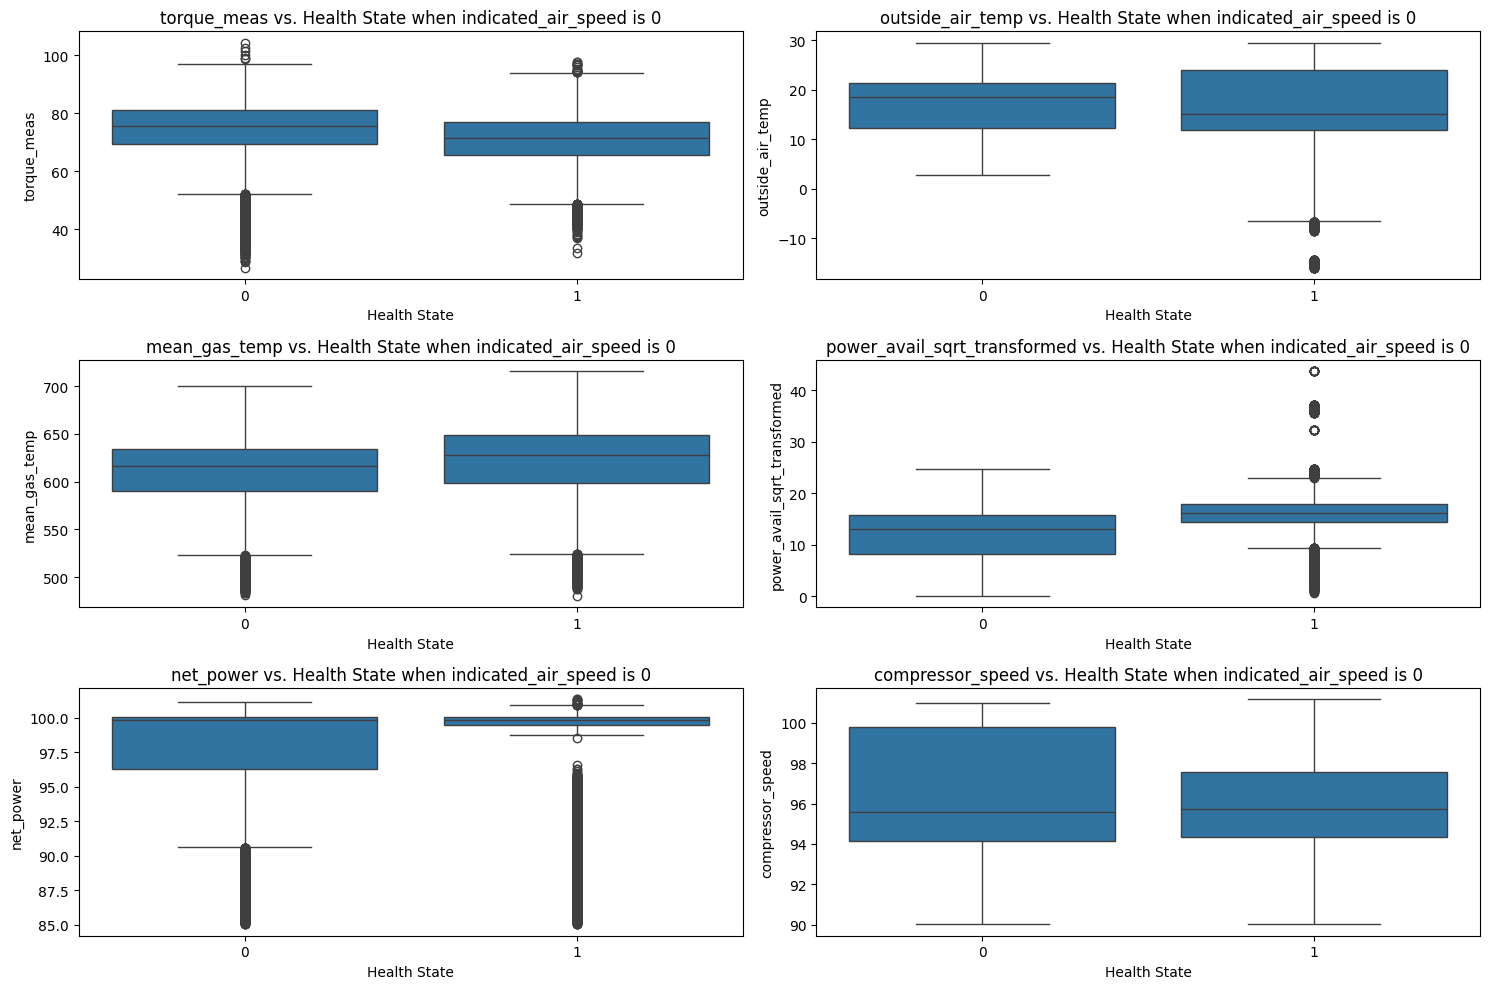


Distribution of 'health_state' when 'indicated_air_speed' is 0:
health_state
0    15235
1     9283
Name: count, dtype: int64

Correlation matrix for selected variables when 'indicated_air_speed' is 0:


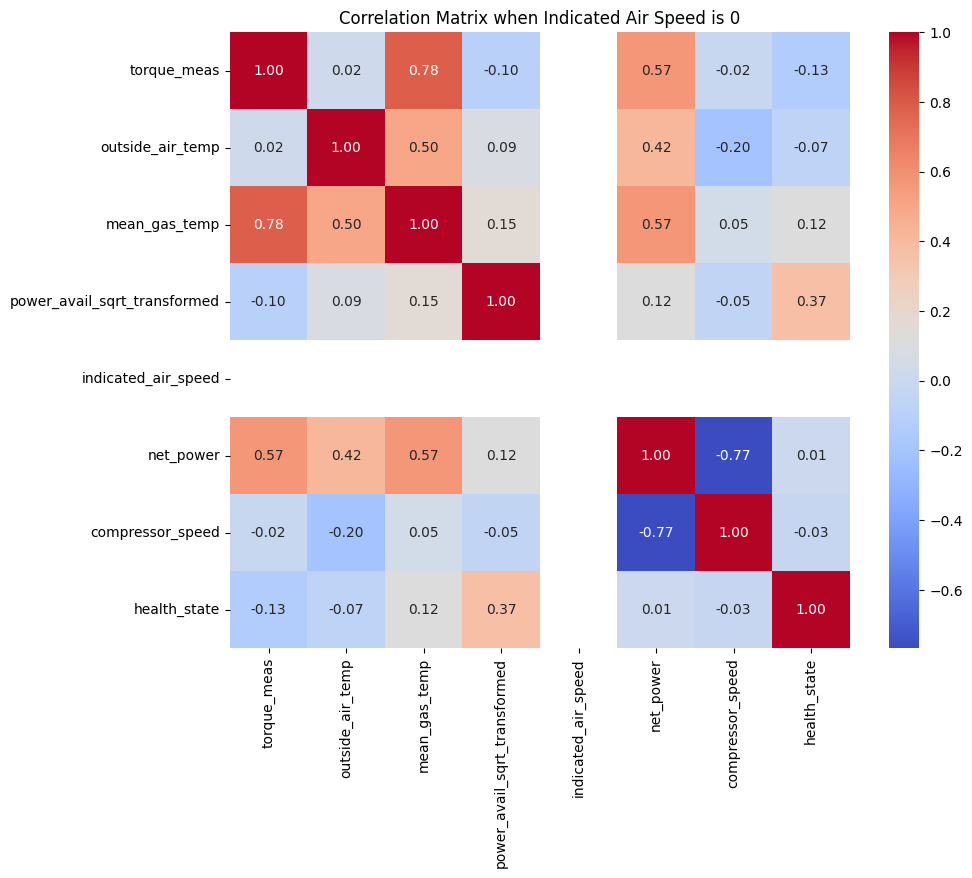

In [14]:
# Analyze the distribution of other variables when indicated_air_speed is zero

# Plotting histograms for relevant columns when indicated_air_speed is zero
columns_to_plot_at_zero_speed = [
    'torque_meas',
    'outside_air_temp',
    'mean_gas_temp',
    'power_avail_sqrt_transformed', # Using the transformed 'power_avail'
    'net_power',
    'compressor_speed',
]

print("\nHistograms of variables when 'indicated_air_speed' is 0:")
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_plot_at_zero_speed):
    plt.subplot(3, 2, i + 1)
    sns.histplot(selected_columns_at_zero_speed[col], kde=True)
    plt.title(f'Distribution of "{col}" when indicated_air_speed is 0')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Analyze the relationship with 'health_state' when indicated_air_speed is zero
print("\nRelationship between selected variables and 'health_state' when 'indicated_air_speed' is 0:")

# Box plots for numerical variables vs. health_state
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_plot_at_zero_speed):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x='health_state', y=col, data=selected_columns_at_zero_speed)
    plt.title(f'{col} vs. Health State when indicated_air_speed is 0')
    plt.xlabel('Health State')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Count of health states when indicated_air_speed is zero
print("\nDistribution of 'health_state' when 'indicated_air_speed' is 0:")
print(selected_columns_at_zero_speed['health_state'].value_counts())

# You could also explore correlations within the indicated_air_speed_zero_data subset
print("\nCorrelation matrix for selected variables when 'indicated_air_speed' is 0:")
correlation_matrix_zero_speed = selected_columns_at_zero_speed.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_zero_speed, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix when Indicated Air Speed is 0')
plt.show()

### Gestione di zero inflated data

## Trasformazioni su net_power

Sottrae alla colonna della feature net power il valore minimo e poi eleva al cubo. Sottrae il valore centrale e calcola il valore assoluto.

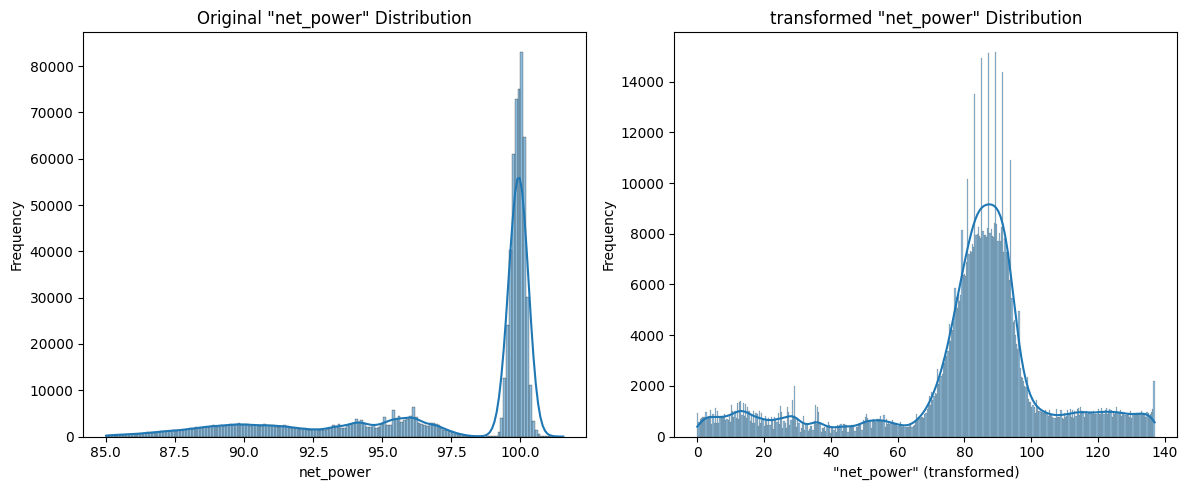


Descriptive statistics for original and transformed 'net_power':
           net_power  net_power_transformed
count  742625.000000          742625.000000
mean       97.377919              80.773705
std         3.996721              27.385604
min        85.010000               0.061250
25%        95.330000              76.793150
50%        99.759770              85.356850
75%       100.020000              92.571250
max       101.560000             136.951250


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
def transform_abs_squared(df, column_name='net_power'):
  """
  Sottrae il valore minimo dalla colonna 'net_power' e poi eleva al quadrato il risultato. Sottrae il valore centrale e calcola il valore assoluto

  Args:
    df (pd.DataFrame): Il DataFrame di input.
    column_name (str): Il nome della colonna da trasformare (default è 'net_power').

  Returns:
    pd.DataFrame: Il DataFrame con la nuova colonna trasformata.
  """
  if column_name not in df.columns:
    raise ValueError(f"La colonna '{column_name}' non è presente nel DataFrame.")

  min_value = df[column_name].min()
  df[f'{column_name}_transformed'] = (df[column_name] - min_value) ** 2
  min_value_t = df[f'{column_name}_transformed'].min()
  max_value_t = df[f'{column_name}_transformed'].max()
  centre_value_t= (min_value_t + max_value_t) / 2
  df[f'{column_name}_transformed'] = abs(df[f'{column_name}_transformed']- centre_value_t)


  return df




# Apply the cube transformation to the 'net_power' column
data_train = transform_abs_squared(data_train.copy(), 'net_power')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['net_power'], kde=True)
plt.title('Original "net_power" Distribution')
plt.xlabel('net_power')
plt.ylabel('Frequency')

# Transformed histogram (transformed)
plt.subplot(1, 2, 2)
sns.histplot(data_train['net_power_transformed'], kde=True)
plt.title('transformed "net_power" Distribution')
plt.xlabel('"net_power" (transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and transformed 'net_power':")
print(data_train[['net_power', 'net_power_transformed']].describe())

### Creazione di variabili binarie
Considerando la grande quantità di dati in prossimità del 100, provo a creare una variabile binaria che valga 1 per valori tra 98 e 102 e 0 per sotto il 98

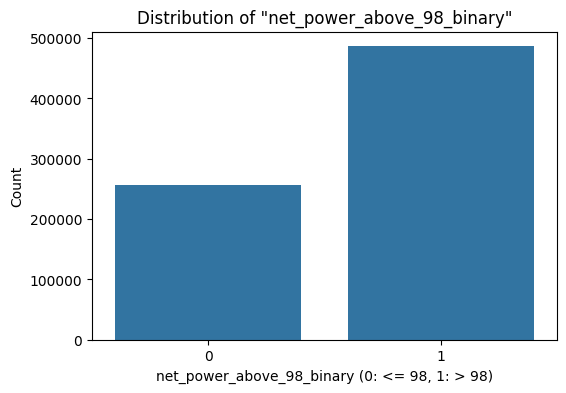


Value counts for the binary 'net_power' variable:
net_power_above_98_binary
1    486611
0    256014
Name: count, dtype: int64


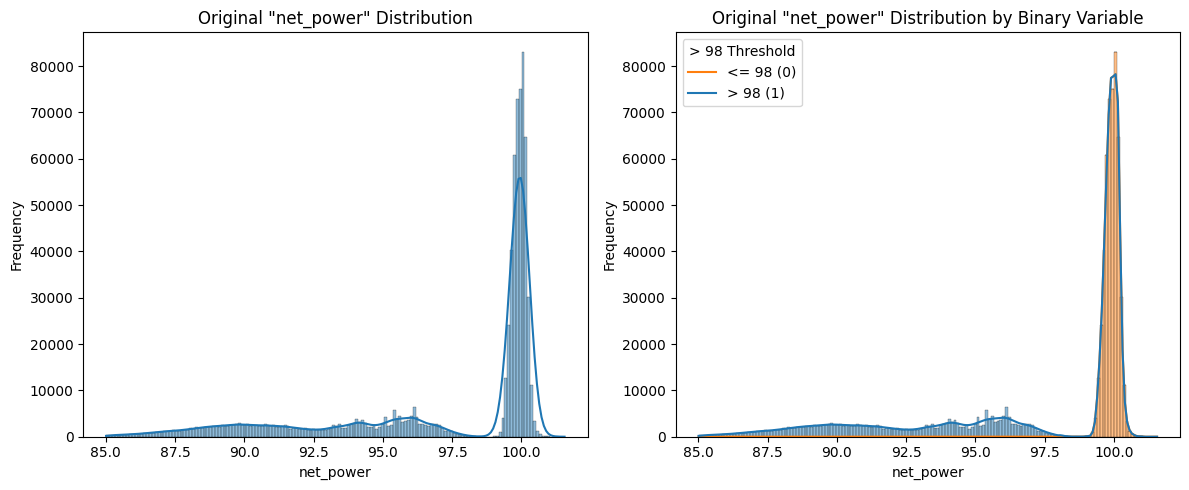

In [16]:
def create_binary_var(df, column_name, threshold=98):
  """
  Creates a binary variable for 'net_power' which is 1 for values above a threshold
  and 0 for values below or equal to the threshold.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to base the binary variable on (default is 'net_power').
    threshold (float): The threshold value. Values strictly greater than this will be 1.

  Returns:
    pd.DataFrame: The DataFrame with the new binary column.
  """
  if column_name not in df.columns:
    raise ValueError(f"La colonna '{column_name}' non è presente nel DataFrame.")

  df[f'{column_name}_above_{threshold}_binary'] = (df[column_name] > threshold).astype(int)

  return df

# Apply the binary transformation to the 'net_power' column with threshold 98
data_train = create_binary_var(data_train.copy(), 'net_power', 98)

# Plotting the distribution of the new binary variable
plt.figure(figsize=(6, 4))
sns.countplot(x='net_power_above_98_binary', data=data_train)
plt.title('Distribution of "net_power_above_98_binary"')
plt.xlabel('net_power_above_98_binary (0: <= 98, 1: > 98)')
plt.ylabel('Count')
plt.show()

print("\nValue counts for the binary 'net_power' variable:")
print(data_train['net_power_above_98_binary'].value_counts())

# Comparison plots with the previous transformation if desired
# You can plot side-by-side histograms or other comparisons depending on your goal.

# Example: Compare the original 'net_power' distribution with the new binary variable's effect
# This might involve filtering the original data based on the binary variable.

plt.figure(figsize=(12, 5))

# Original 'net_power' distribution (same as before for reference)
plt.subplot(1, 2, 1)
sns.histplot(data_train['net_power'], kde=True)
plt.title('Original "net_power" Distribution')
plt.xlabel('net_power')
plt.ylabel('Frequency')

# Distribution of original 'net_power' split by the binary variable
plt.subplot(1, 2, 2)
sns.histplot(data_train, x='net_power', hue='net_power_above_98_binary', multiple="stack", kde=True)
plt.title('Original "net_power" Distribution by Binary Variable')
plt.xlabel('net_power')
plt.ylabel('Frequency')
plt.legend(title='> 98 Threshold', labels=['<= 98 (0)', '> 98 (1)']) # Adjust labels if needed

plt.tight_layout()
plt.show()

### Istogrammi correlazioni stati variabile binaria altre variabili

Per la variabile binaria appena creata vorrei provare a vedere con grafici come si comportano le altre feature per capire cosa significa che net_power sia tra 85-98 o superiore


Visualizing distributions of other variables based on 'net_power_above_98_binary':


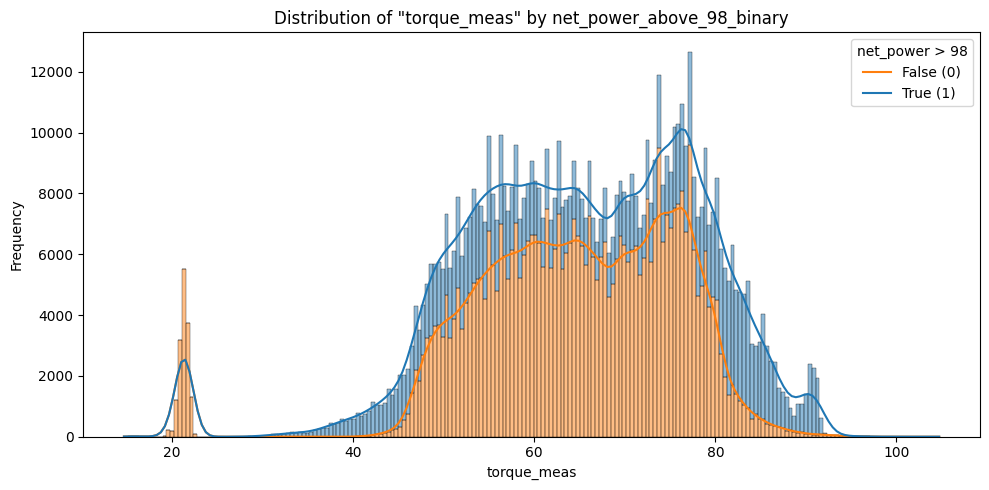


Descriptive statistics for 'torque_meas' grouped by 'net_power_above_98_binary':
                              count       mean        std       min       25%  \
net_power_above_98_binary                                                       
0                          256014.0  66.964114  14.625289  26.40000  54.30000   
1                          486611.0  64.115518  12.358985  14.67334  56.83301   

                            50%   75%       max  
net_power_above_98_binary                        
0                          68.3  80.3   99.0000  
1                          65.1  73.6  104.7305  


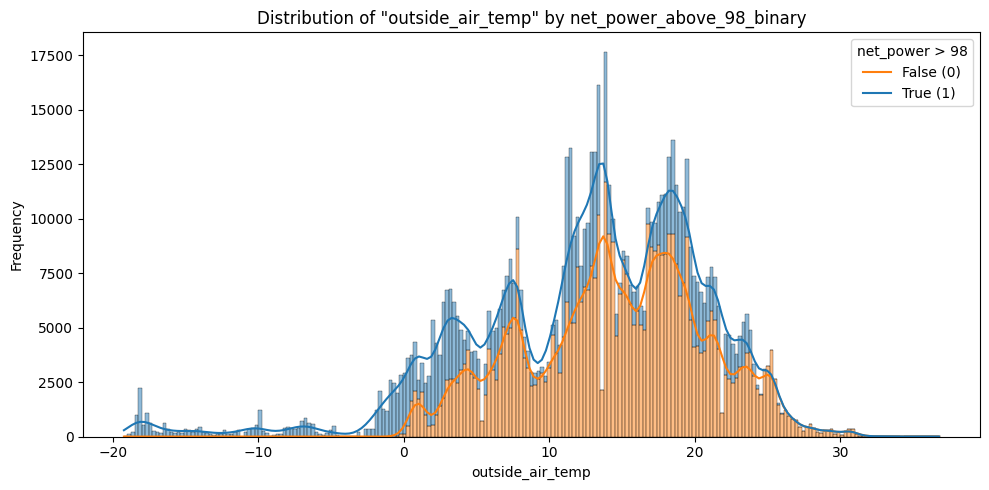


Descriptive statistics for 'outside_air_temp' grouped by 'net_power_above_98_binary':
                              count       mean       std    min   25%  \
net_power_above_98_binary                                               
0                          256014.0   9.024598  9.764876 -19.25   2.5   
1                          486611.0  14.595791  6.198794  -0.50  10.5   

                                50%       75%       max  
net_power_above_98_binary                                
0                          11.25000  17.75000  29.50000  
1                          14.89411  18.79897  36.79913  


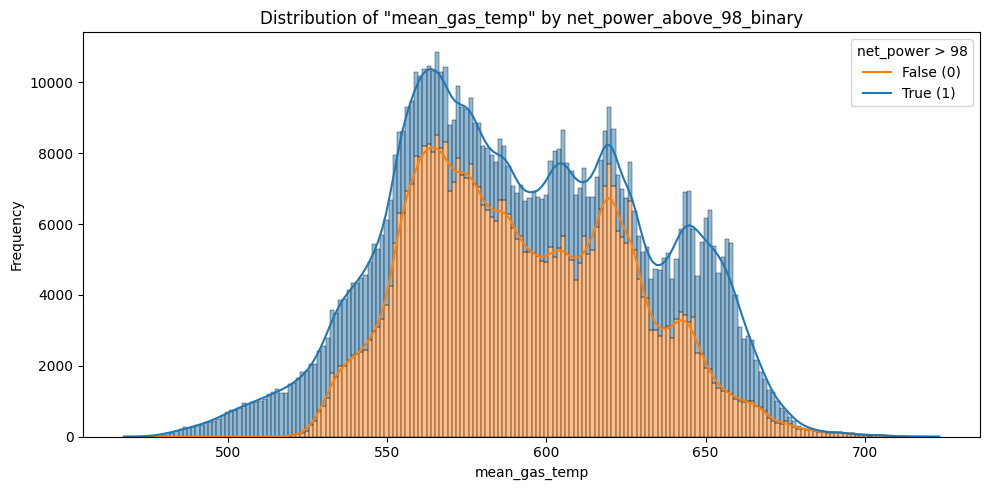


Descriptive statistics for 'mean_gas_temp' grouped by 'net_power_above_98_binary':
                              count        mean        std    min       25%  \
net_power_above_98_binary                                                     
0                          256014.0  591.274122  49.763170  467.3  549.8000   
1                          486611.0  592.757498  33.108632  512.9  565.9688   

                                50%       75%    max  
net_power_above_98_binary                             
0                          593.1000  640.3000  689.1  
1                          588.6406  618.5469  723.4  


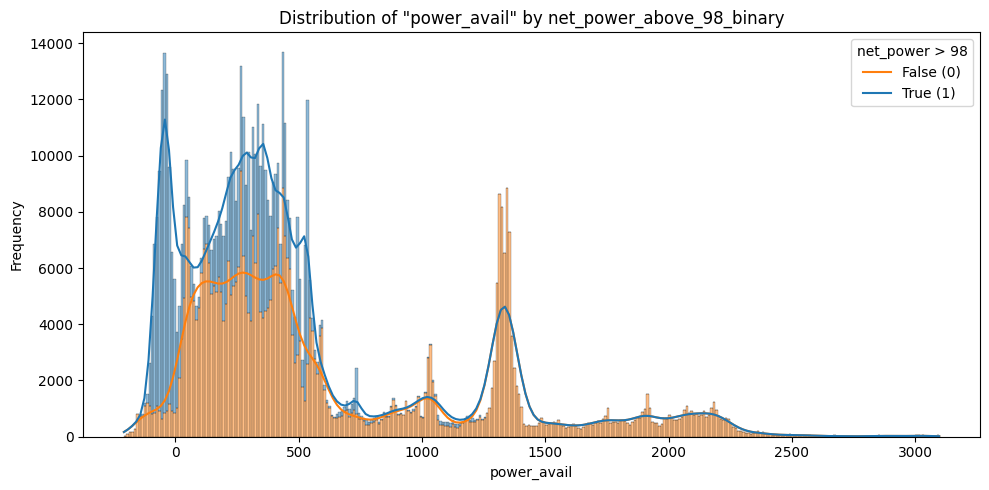


Descriptive statistics for 'power_avail' grouped by 'net_power_above_98_binary':
                              count        mean         std       min  \
net_power_above_98_binary                                               
0                          256014.0  215.382695  238.511985 -140.5128   
1                          486611.0  667.713462  619.349949 -208.3892   

                                25%       50%        75%       max  
net_power_above_98_binary                                           
0                          -27.7368  231.3432   379.1712  1259.434  
1                          211.5312  423.0624  1190.5975  3097.510  


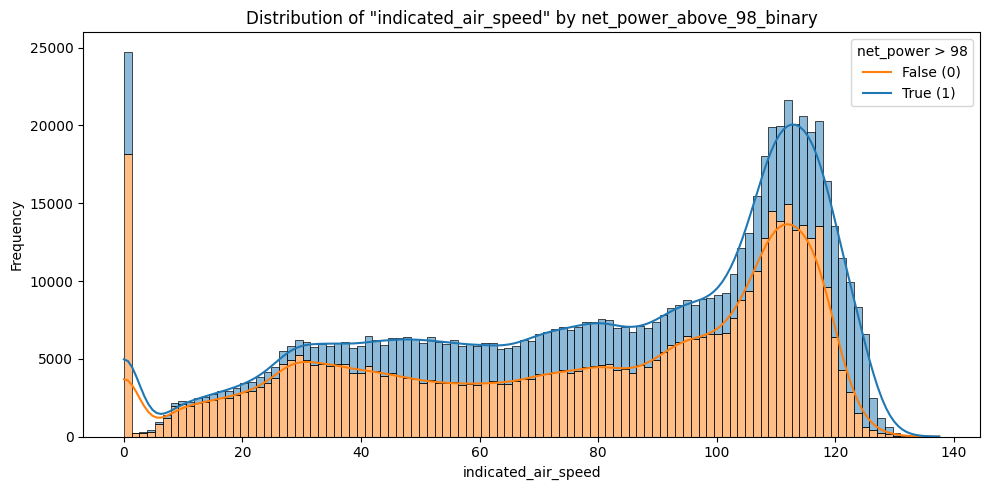


Descriptive statistics for 'indicated_air_speed' grouped by 'net_power_above_98_binary':
                              count       mean        std  min     25%  \
net_power_above_98_binary                                                
0                          256014.0  85.355642  33.040937  0.0  60.375   
1                          486611.0  76.151557  36.171401  0.0  44.750   

                              50%       75%       max  
net_power_above_98_binary                              
0                          92.500  114.1875  137.5625  
1                          86.125  108.8125  130.9531  


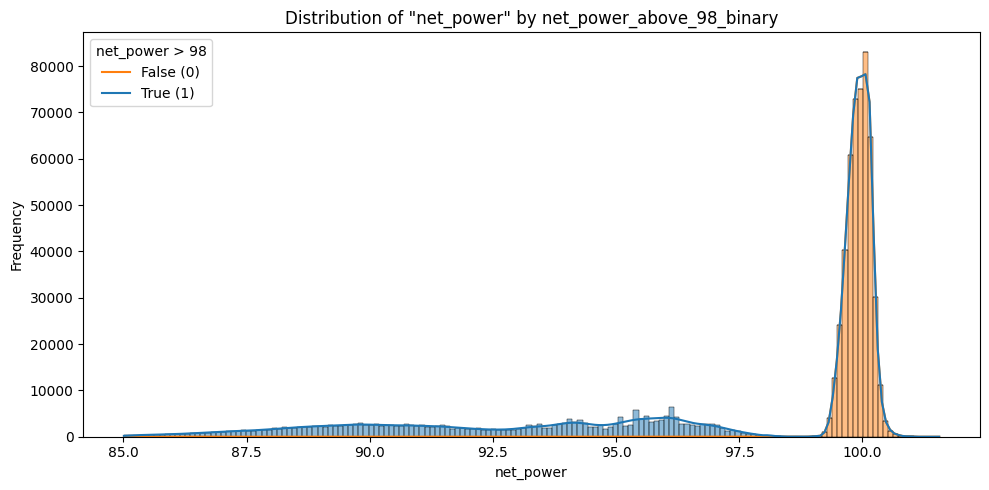


Descriptive statistics for 'net_power' grouped by 'net_power_above_98_binary':
                              count       mean       std    min    25%    50%  \
net_power_above_98_binary                                                       
0                          256014.0  92.531873  3.222806  85.01  89.83  93.01   
1                          486611.0  99.927503  0.239911  98.01  99.77  99.94   

                              75%     max  
net_power_above_98_binary                  
0                           95.45   98.00  
1                          100.10  101.56  


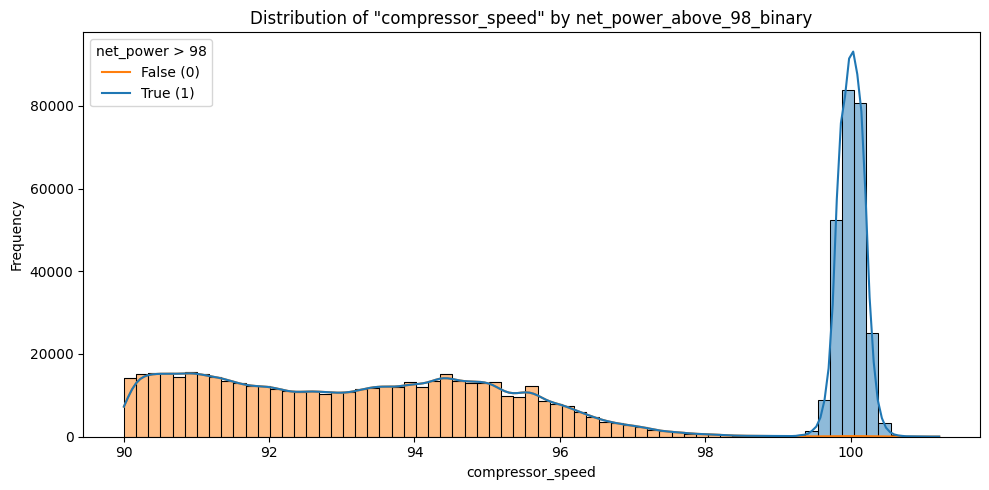


Descriptive statistics for 'compressor_speed' grouped by 'net_power_above_98_binary':
                              count        mean       std       min       25%  \
net_power_above_98_binary                                                       
0                          256014.0  100.009272  0.179382  91.37000  99.89000   
1                          486611.0   93.153971  1.986881  90.00183  91.36316   

                              50%     75%     max  
net_power_above_98_binary                          
0                          100.01  100.13  101.22  
1                           93.13   94.74  100.66  


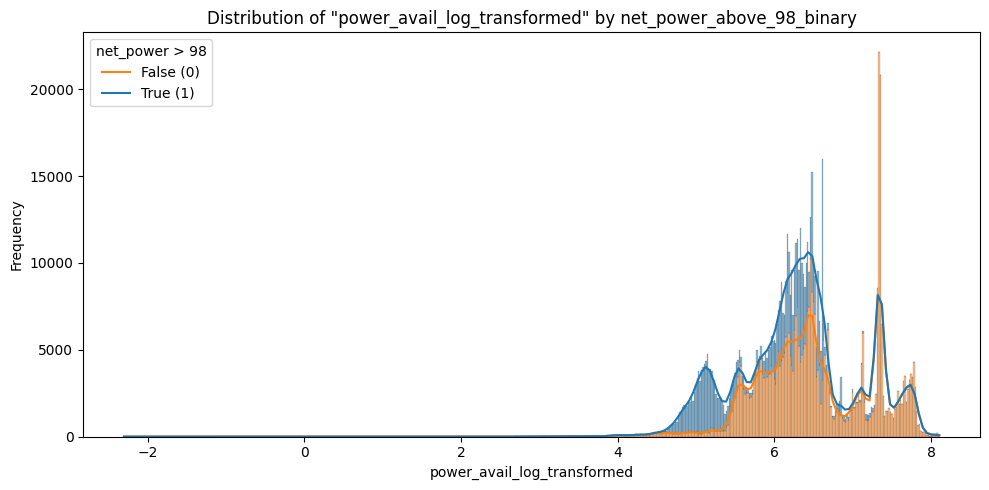


Descriptive statistics for 'power_avail_log_transformed' grouped by 'net_power_above_98_binary':
                              count      mean       std       min       25%  \
net_power_above_98_binary                                                     
0                          256014.0  5.867499  0.632315  4.219161  5.197128   
1                          486611.0  6.526077  0.729419 -2.302585  6.040303   

                                50%       75%       max  
net_power_above_98_binary                                
0                          6.086394  6.376149  7.291604  
1                          6.448180  7.243575  8.103494  


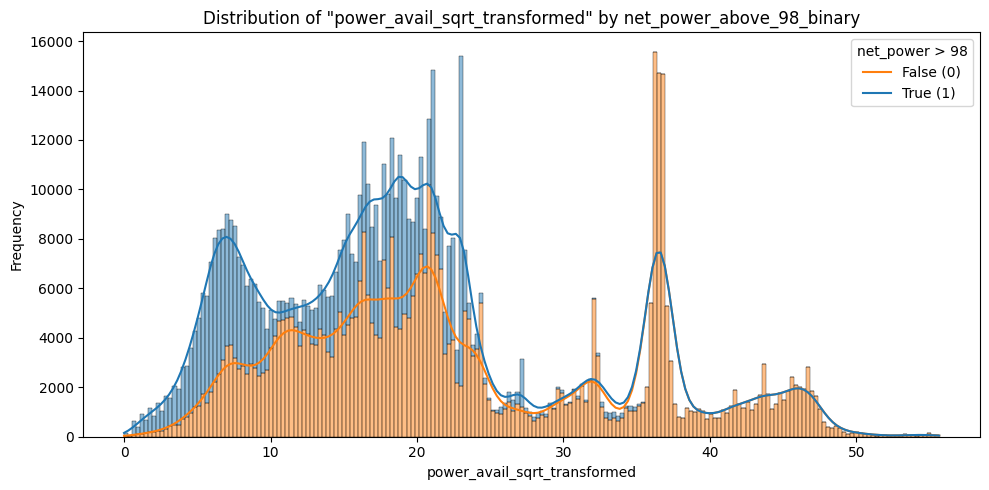


Descriptive statistics for 'power_avail_sqrt_transformed' grouped by 'net_power_above_98_binary':
                              count       mean        std  min        25%  \
net_power_above_98_binary                                                   
0                          256014.0  14.063866   6.967568  0.0   7.345039   
1                          486611.0  23.220561  11.563362  0.0  14.544112   

                                 50%        75%        max  
net_power_above_98_binary                                   
0                          15.209970  19.472319  35.488505  
1                          20.568481  34.505036  55.655278  


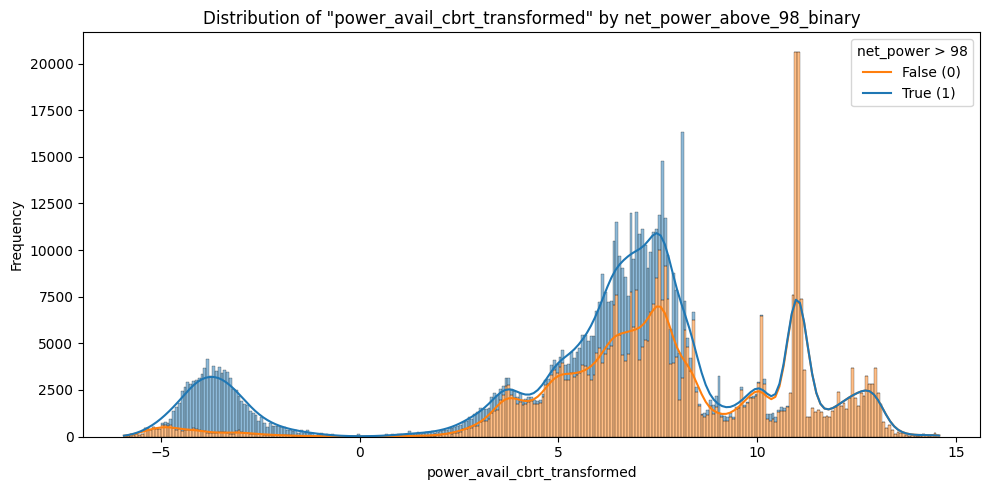


Descriptive statistics for 'power_avail_cbrt_transformed' grouped by 'net_power_above_98_binary':
                              count      mean       std       min       25%  \
net_power_above_98_binary                                                     
0                          256014.0  3.410214  4.924371 -5.198826 -3.027044   
1                          486611.0  7.648792  3.373381 -5.928685  5.958334   

                               50%        75%        max  
net_power_above_98_binary                                 
0                          6.13883   7.237887  10.799205  
1                          7.50703  10.598758  14.577092  


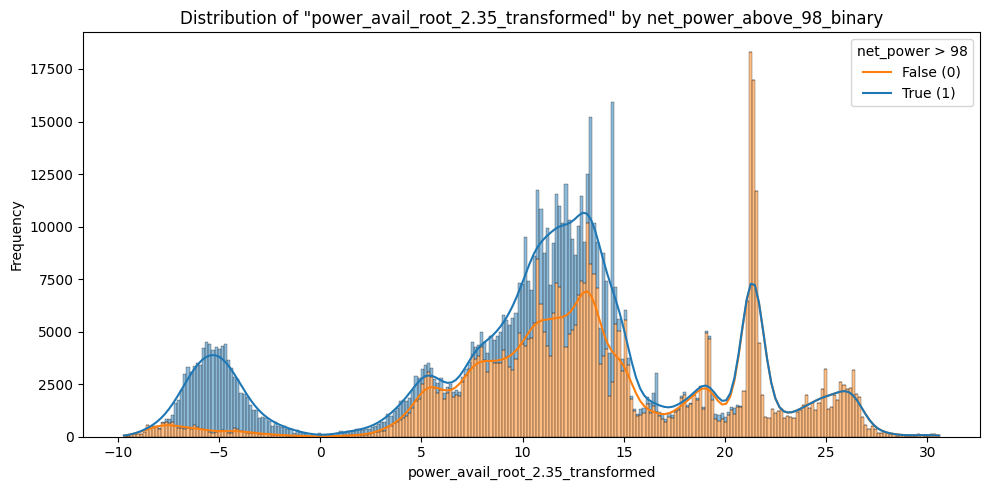


Descriptive statistics for 'power_avail_root_2.35_transformed' grouped by 'net_power_above_98_binary':
                              count       mean       std       min       25%  \
net_power_above_98_binary                                                      
0                          256014.0   6.134732  8.107769 -8.202036 -4.112127   
1                          486611.0  13.916687  6.980218 -9.699635  9.761601   

                                 50%        75%        max  
net_power_above_98_binary                                   
0                          10.140671  12.513441  20.855643  
1                          13.110489  20.362737  30.587031  


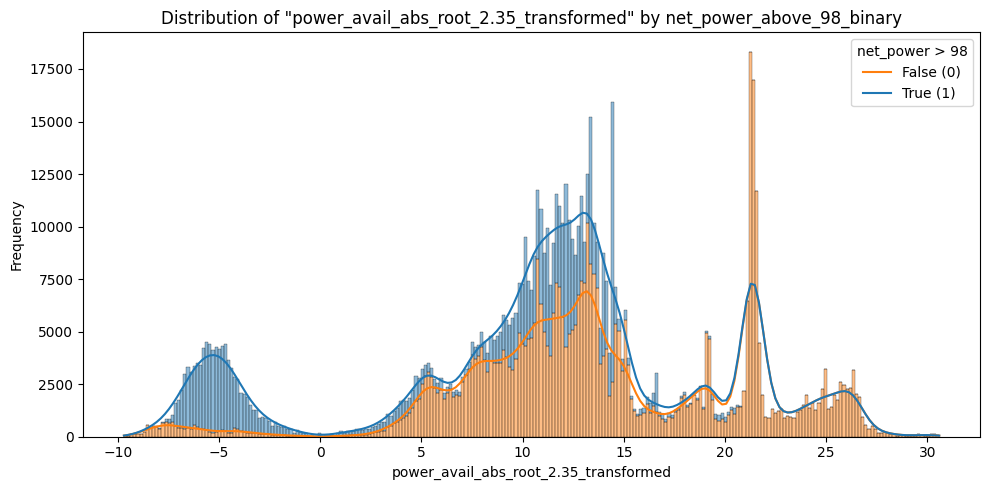


Descriptive statistics for 'power_avail_abs_root_2.35_transformed' grouped by 'net_power_above_98_binary':
                              count       mean       std       min       25%  \
net_power_above_98_binary                                                      
0                          256014.0   6.134732  8.107769 -8.202036 -4.112127   
1                          486611.0  13.916687  6.980218 -9.699635  9.761601   

                                 50%        75%        max  
net_power_above_98_binary                                   
0                          10.140671  12.513441  20.855643  
1                          13.110489  20.362737  30.587031  


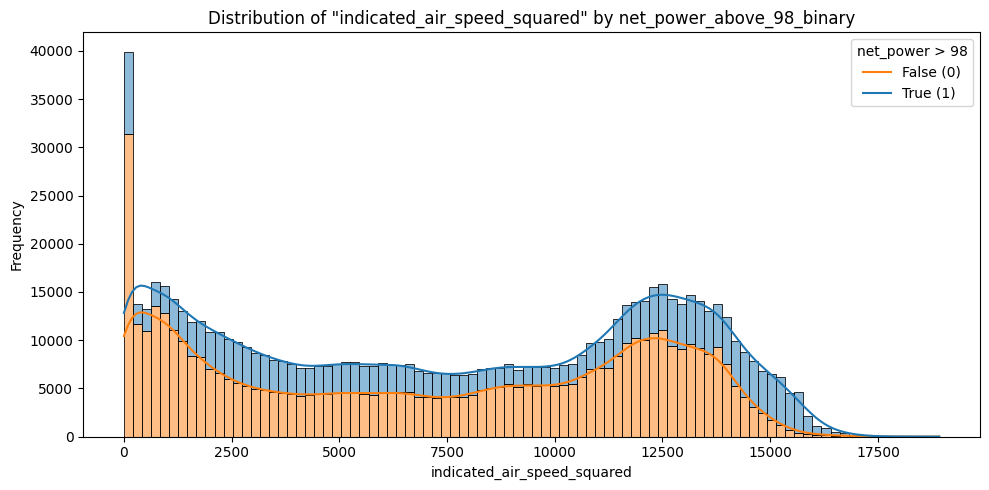


Descriptive statistics for 'indicated_air_speed_squared' grouped by 'net_power_above_98_binary':
                              count         mean         std  min  \
net_power_above_98_binary                                           
0                          256014.0  8377.284921  5012.55376  0.0   
1                          486611.0  7107.427196  4924.48025  0.0   

                                   25%          50%           75%  \
net_power_above_98_binary                                           
0                          3645.140625  8556.250000  13038.785156   
1                          2002.562500  7417.515625  11840.160156   

                                    max  
net_power_above_98_binary                
0                          18923.441406  
1                          17148.714400  


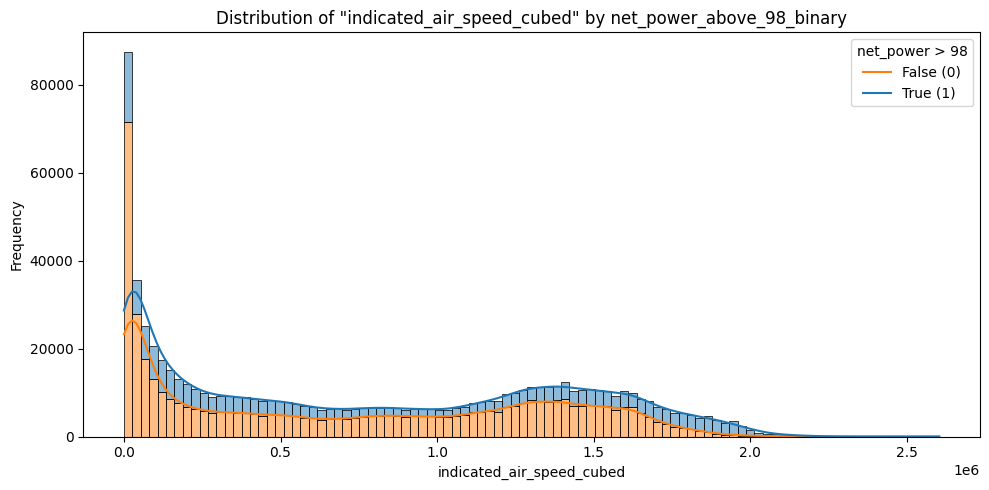


Descriptive statistics for 'indicated_air_speed_cubed' grouped by 'net_power_above_98_binary':
                              count           mean            std  min  \
net_power_above_98_binary                                                
0                          256014.0  876386.070944  661269.311367  0.0   
1                          486611.0  714840.076970  600052.499616  0.0   

                                     25%            50%           75%  \
net_power_above_98_binary                                               
0                          220075.365234  791453.125000  1.488866e+06   
1                           89614.671875  638833.533203  1.288357e+06   

                                    max  
net_power_above_98_binary                
0                          2.603156e+06  
1                          2.245677e+06  


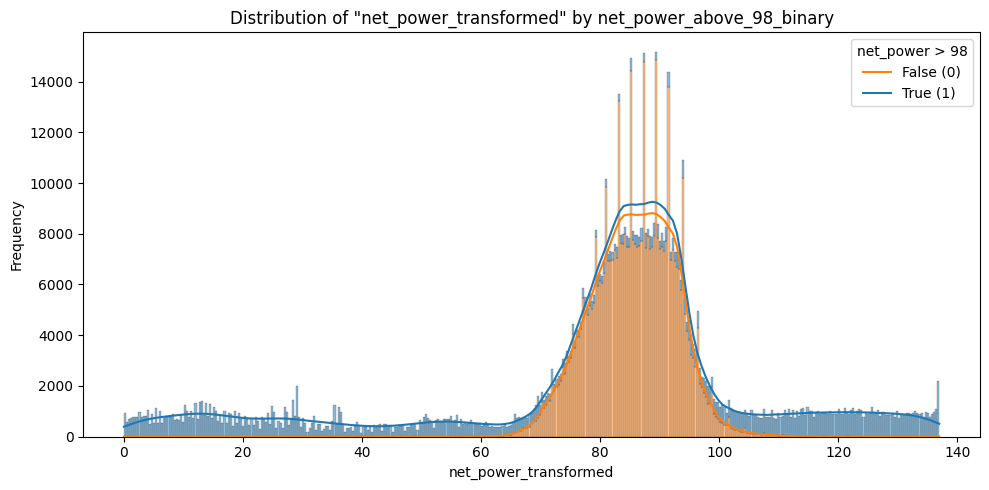


Descriptive statistics for 'net_power_transformed' grouped by 'net_power_above_98_binary':
                              count       mean        std       min       25%  \
net_power_above_98_binary                                                       
0                          256014.0  71.527630  44.138811   0.06125  28.37485   
1                          486611.0  85.638216   7.134906  32.04875  80.90635   

                                50%        75%        max  
net_power_above_98_binary                                  
0                          72.95125  113.71885  136.95125  
1                          85.95365   90.75685  136.95125  


In [17]:
# prompt: per net_power_above_98_binary=0 e =1 vorrei vedere istogrammi di come variano le altre variabili di data_train

# Analyze the distribution of other variables based on the binary 'net_power_above_98_binary' variable

# List of columns to visualize (excluding index, target, and the binary variable itself)
columns_to_plot_by_binary = [col for col in data_train.columns if col not in ['idx', 'health_state', 'net_power_above_98_binary']]

print("\nVisualizing distributions of other variables based on 'net_power_above_98_binary':")

# Loop through each column and plot histograms or box plots
for col in columns_to_plot_by_binary:
    plt.figure(figsize=(10, 5))

    # Use histplot for numerical columns
    if data_train[col].dtype in ['float64', 'int64']:
        sns.histplot(data_train, x=col, hue='net_power_above_98_binary', multiple="stack", kde=True)
        plt.title(f'Distribution of "{col}" by net_power_above_98_binary')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend(title='net_power > 98', labels=['False (0)', 'True (1)'])

    # You might want to add different plots for categorical columns if any
    # elif data_train[col].dtype == 'object':
    #     sns.countplot(x=col, hue='net_power_above_98_binary', data=data_train)
    #     plt.title(f'Count of "{col}" by net_power_above_98_binary')
    #     plt.xlabel(col)
    #     plt.ylabel('Count')
    #     plt.legend(title='net_power > 98', labels=['False (0)', 'True (1)'])

    plt.tight_layout()
    plt.show()

    # Also useful to see descriptive statistics for each group
    print(f"\nDescriptive statistics for '{col}' grouped by 'net_power_above_98_binary':")
    print(data_train.groupby('net_power_above_98_binary')[col].describe())

## Trasformazioni su compressor_speed
Provo ad applicare la stessa trasformazione di net_power anche su compressor_speed dato che hanno andamenti simili

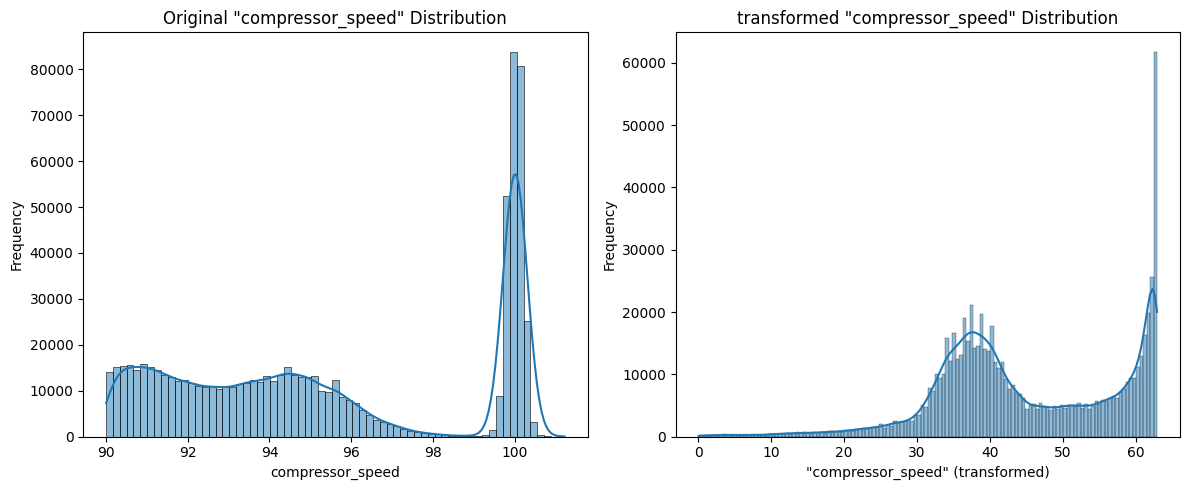


Descriptive statistics for original and transformed 'compressor_speed':
       compressor_speed  compressor_speed_transformed
count     742625.000000                 742625.000000
mean          95.517281                     45.064379
std            3.635084                     12.531420
min           90.001830                      0.012597
25%           92.226440                     36.241481
50%           94.810000                     42.101319
75%           99.900000                     57.974779
max          101.220000                     62.923669


In [18]:
# Apply the cube transformation to the 'compressor_speed' column
data_train = transform_abs_squared(data_train.copy(), 'compressor_speed')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['compressor_speed'], kde=True)
plt.title('Original "compressor_speed" Distribution')
plt.xlabel('compressor_speed')
plt.ylabel('Frequency')

# Transformed histogram (transformed)
plt.subplot(1, 2, 2)
sns.histplot(data_train['compressor_speed_transformed'], kde=True)
plt.title('transformed "compressor_speed" Distribution')
plt.xlabel('"compressor_speed" (transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and transformed 'compressor_speed':")
print(data_train[['compressor_speed', 'compressor_speed_transformed']].describe())

Provo a trasformare utilizzando una trasformazione simile, ma senza elevare al quadrato.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
def transform_abs(df, column_name='net_power'):
  """
  Sottrae il valore minimo dalla colonna 'net_power' e poi eleva al quadrato il risultato. Sottrae il valore centrale e calcola il valore assoluto

  Args:
    df (pd.DataFrame): Il DataFrame di input.
    column_name (str): Il nome della colonna da trasformare (default è 'net_power').

  Returns:
    pd.DataFrame: Il DataFrame con la nuova colonna trasformata.
  """
  if column_name not in df.columns:
    raise ValueError(f"La colonna '{column_name}' non è presente nel DataFrame.")

  min_value = df[column_name].min()
  df[f'{column_name}_transformed'] = (df[column_name] - min_value)
  min_value_t = df[f'{column_name}_transformed'].min()
  max_value_t = df[f'{column_name}_transformed'].max()
  centre_value_t= (min_value_t + max_value_t) / 2
  df[f'{column_name}_transformed'] = abs(df[f'{column_name}_transformed']- centre_value_t)


  return df

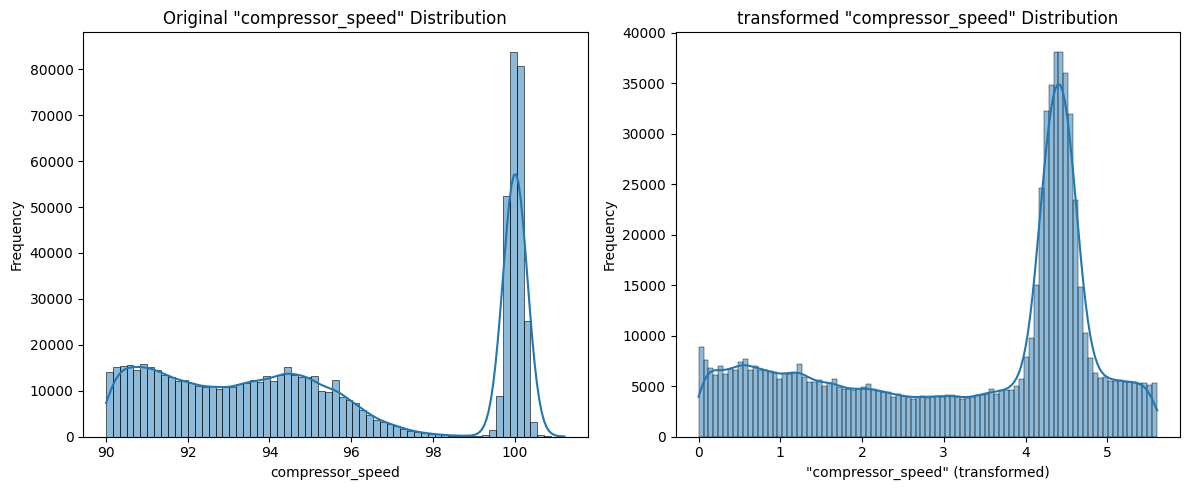


Descriptive statistics for original and transformed 'compressor_speed':
       compressor_speed  compressor_speed_transformed
count     742625.000000                 742625.000000
mean          95.517281                      3.253574
std            3.635084                      1.623836
min           90.001830                      0.000295
25%           92.226440                      1.743845
50%           94.810000                      4.139085
75%           99.900000                      4.479085
max          101.220000                      5.609085


In [20]:
# Apply the cube transformation to the 'compressor_speed' column
data_train = transform_abs(data_train.copy(), 'compressor_speed')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['compressor_speed'], kde=True)
plt.title('Original "compressor_speed" Distribution')
plt.xlabel('compressor_speed')
plt.ylabel('Frequency')

# Transformed histogram (transformed)
plt.subplot(1, 2, 2)
sns.histplot(data_train['compressor_speed_transformed'], kde=True)
plt.title('transformed "compressor_speed" Distribution')
plt.xlabel('"compressor_speed" (transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and transformed 'compressor_speed':")
print(data_train[['compressor_speed', 'compressor_speed_transformed']].describe())

### Creazione variabile binaria

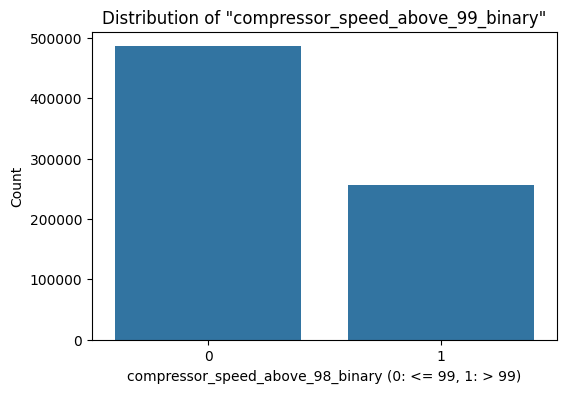


Value counts for the binary 'compressor_speed' variable:
compressor_speed_above_99_binary
0    486038
1    256587
Name: count, dtype: int64


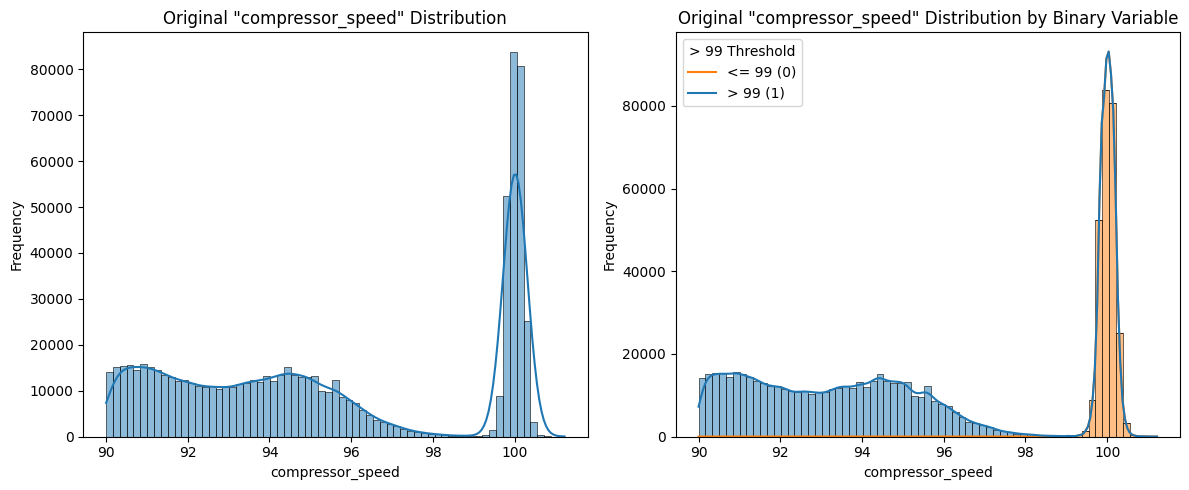

In [21]:
# Apply the binary transformation to the 'compressor_speed' column with threshold 98
data_train = create_binary_var(data_train.copy(), 'compressor_speed', 99)

# Plotting the distribution of the new binary variable
plt.figure(figsize=(6, 4))
sns.countplot(x='compressor_speed_above_99_binary', data=data_train)
plt.title('Distribution of "compressor_speed_above_99_binary"')
plt.xlabel('compressor_speed_above_98_binary (0: <= 99, 1: > 99)')
plt.ylabel('Count')
plt.show()

print("\nValue counts for the binary 'compressor_speed' variable:")
print(data_train['compressor_speed_above_99_binary'].value_counts())

# Comparison plots with the previous transformation if desired
# You can plot side-by-side histograms or other comparisons depending on your goal.

# Example: Compare the original 'compressor_speed' distribution with the new binary variable's effect
# This might involve filtering the original data based on the binary variable.

plt.figure(figsize=(12, 5))

# Original 'compressor_speed' distribution (same as before for reference)
plt.subplot(1, 2, 1)
sns.histplot(data_train['compressor_speed'], kde=True)
plt.title('Original "compressor_speed" Distribution')
plt.xlabel('compressor_speed')
plt.ylabel('Frequency')

# Distribution of original 'compressor_speed' split by the binary variable
plt.subplot(1, 2, 2)
sns.histplot(data_train, x='compressor_speed', hue='compressor_speed_above_99_binary', multiple="stack", kde=True)
plt.title('Original "compressor_speed" Distribution by Binary Variable')
plt.xlabel('compressor_speed')
plt.ylabel('Frequency')
plt.legend(title='> 99 Threshold', labels=['<= 99 (0)', '> 99 (1)']) # Adjust labels if needed

plt.tight_layout()
plt.show()

### Correlation matrix
Era stato notato che net_power e compressor_speed hanno una forte correlazione di -0.78, hanno forme visivamente simili, quindi poteva essere intuibile un legame tra le due. Ora che sono state introdotte le variabili binarie, è possibile notare quante queste siano fortemente correlate, per alcuni valori di threshold è addiritura -1 l'indice di correlazione, questo porta a farci pensare di utilizzare solo una delle due variabili per analisi dati.

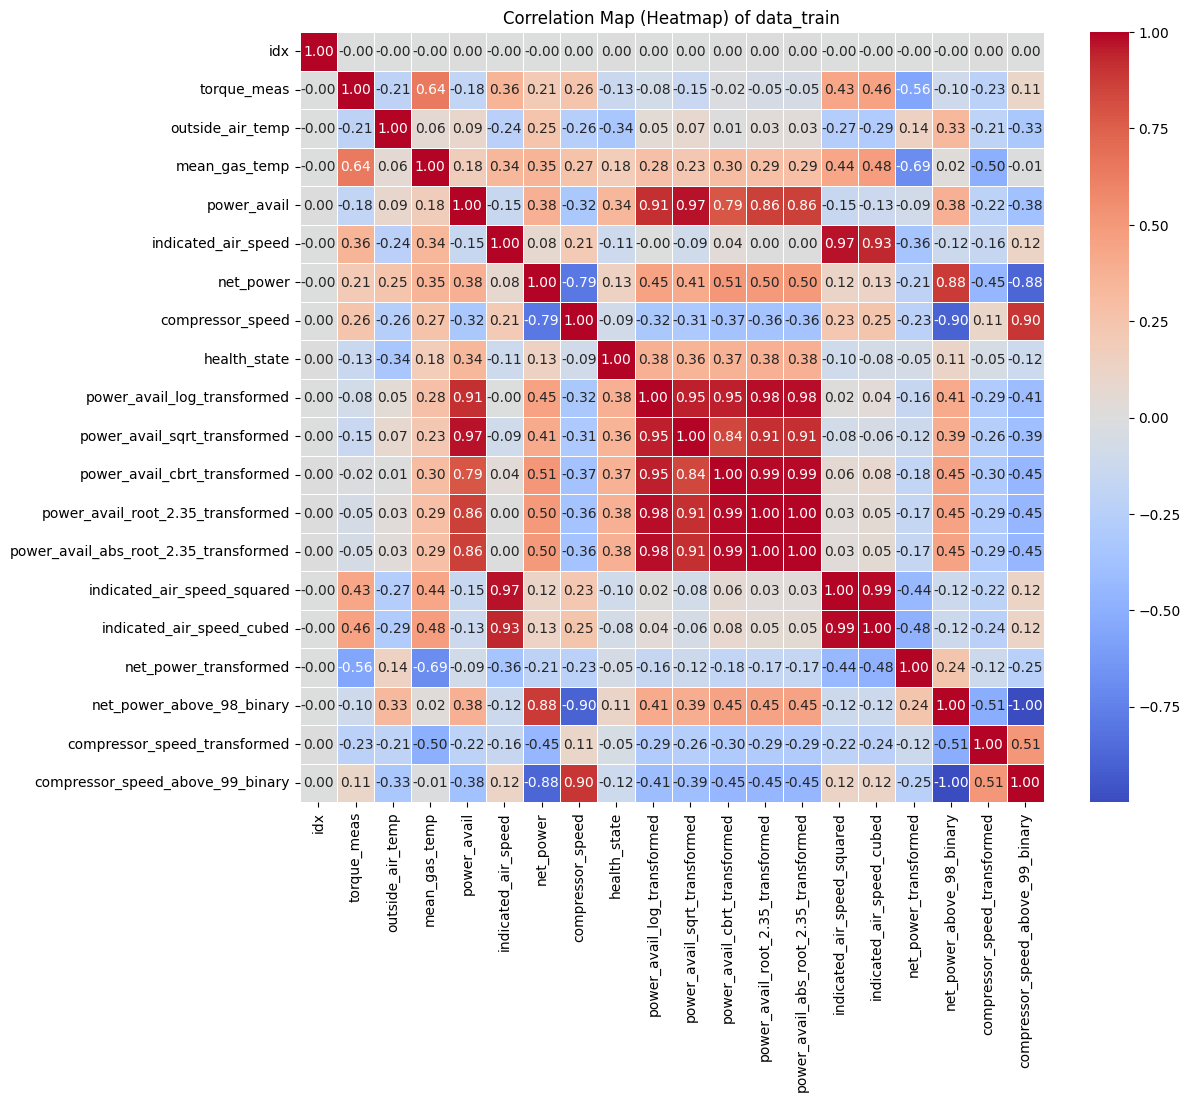

In [22]:
# Calculate the correlation matrix
correlation_matrix = data_train.corr()

# Create a correlation map (heatmap)
plt.figure(figsize=(12, 10)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Map (Heatmap) of data_train')
plt.show()